In [ ]:
!pip install nilearn
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 72.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import nibabel as nib
from pathlib import Path
import re
import warnings
import pandas as pd
import pickle  # --- IMPORT PICKLE ---

# Import nilearn modules for feature extraction
from nilearn.datasets import fetch_atlas_aal
# --- UPDATED: Use NiftiLabelsMasker for a labeled 3D atlas ---
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import resample_to_img

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_and_process_fmri(data_dir="/content/drive/MyDrive/CraveMultimodal/data/Functional", t_r=None):
    """
    Loads all functional .nii and .nii.gz files from a directory, extracts
    a combined set of statistical features, and returns a dictionary.

    The features are a concatenated 1D array containing:
    1.  Functional Connectivity (FC): Flattened upper-triangle of the
        correlation matrix from the Harvard-Oxford 48-region cortical atlas
        (1128 features).
    2.  Amplitude of Low-Frequency Fluctuation (ALFF): The standard deviation
        of the band-passed signal for each of the 48 ROIs (48 features).
    3.  Temporal Signal-to-Noise Ratio (tSNR): The mean tSNR value
        for each of the 48 ROIs (48 features).

    Total features per subject: 1128 + 48 + 48 = 1224 features.

    Args:
        data_dir (str or Path): The directory containing the functional NIfTI files.
        t_r (float, optional): The Repetition Time (TR) in seconds for the fMRI data.
                             This is REQUIRED for temporal filtering.

    Returns:
        tuple: A tuple containing:
            (features_dict, fc_labels, alff_labels, tsnr_labels)
            - features_dict (dict): Keys are subject IDs, values are 1D NumPy arrays.
            - fc_labels (list): List of 1128 FC feature names.
            - alff_labels (list): List of 48 ALFF feature names.
            - tsnr_labels (list): List of 48 tSNR feature names.
    """

    # --- 0. Check for t_r (Repetition Time) ---
    if t_r is None:
        print(f"\n--- ERROR ---")
        print(f"No Repetition Time (t_r) provided.")
        print("t_r is required for the temporal (Butterworth) filter.")
        print("Please find the TR for your fMRI data (e.g., 2.0) and pass it as an argument:")
        print("Example: fmri_features = load_and_process_fmri(data_dir='...', t_r=2.0)")
        print("---------------\n")
        return {}, [], [], []  # Exit function

    # --- 1. Set up nilearn tools (outside the loop) ---

    # Load the AAL cortical atlas
    try:
        print("Loading AAL  atlas (attempting download)...")
        # We use the 2mm atlas with max probability, 25% threshold
        atlas = fetch_atlas_aal(version='SPM12')
        # This is a 3D labels image, not a 4D maps image
        atlas_labels_img = atlas.maps

    except Exception as e:
        print(f"\n--- ERROR ---")
        print(f"Failed to download aal atlas automatically: {e}")
        print("This may be a network issue. Please try again.")
        print("---------------\n")
        return {}, [], [], []  # Exit function if atlas fails

    # --- 1b. Generate Feature Labels ---

    # --- UPDATED: Get actual region names from the atlas ---

    raw_labels = atlas.labels
    # The first label 'Background' is excluded

    region_names = [
    (lab.decode('utf-8') if isinstance(lab, bytes) else lab)
    for lab in raw_labels[1:]
]
    num_rois = len(region_names)  # Should be 116
    num_fc_features = int(num_rois * (num_rois - 1) / 2)  # 48*47/2 = 1128

    print(f"Generating feature labels for {num_rois} ROIs from AAL atlas...")

    # Define a helper to sanitize names (replace spaces/commas/hyphens with '_')
    def sanitize_name(name):
        return re.sub(r'[\s,-]+', '_', name)

    # Generate FC labels (e.g., "FC_Frontal_Pole_to_Insular_Cortex")
    fc_labels = []
    indices = np.triu_indices(num_rois, k=1)
    for i, j in zip(indices[0], indices[1]):
        name_i = sanitize_name(region_names[i])
        name_j = sanitize_name(region_names[j])
        fc_labels.append(f"FC_{name_i}_to_{name_j}")

    # Generate ALFF labels (e.g., "ALFF_Frontal_Pole")
    alff_labels = [f"ALFF_{sanitize_name(name)}" for name in region_names]

    # Generate tSNR labels (e.g., "tSNR_Frontal_Pole")
    tsnr_labels = [f"tSNR_{sanitize_name(name)}" for name in region_names]

    print(f"  - {len(fc_labels)} FC labels")
    print(f"  - {len(alff_labels)} ALFF labels")
    print(f"  - {len(tsnr_labels)} tSNR labels")

    # --- UPDATED: Create THREE NiftiLabelsMasker instances ---

    # 1. FC masker: For extracting cleaned, standardized time series
    fc_masker = NiftiLabelsMasker(
        labels_img=atlas_labels_img,
        standardize=True,  # Z-score time series (Correct for FC)
        detrend=True,  # Remove linear trends
        low_pass=0.08,  # Standard resting-state band-pass filter
        high_pass=0.01,
        t_r=t_r,
        background_label=0,  # Explicitly set background label
        memory='nilearn_cache',  # Cache intermediate results
        verbose=0  # Suppress nilearn messages in loop
    )

    # 2. ALFF masker: For extracting cleaned, non-standardized time series
    alff_masker = NiftiLabelsMasker(
        labels_img=atlas_labels_img,
        standardize=False,  # No standardization (Correct for ALFF)
        detrend=True,  # Remove linear trends
        low_pass=0.08,  # Standard resting-state band-pass filter
        high_pass=0.01,
        t_r=t_r,
        background_label=0,
        memory='nilearn_cache',
        verbose=0
    )

    # 3. tSNR masker: For extracting raw, unprocessed data from ROIs
    tsnr_masker = NiftiLabelsMasker(
        labels_img=atlas_labels_img,
        standardize=False,  # No standardization
        detrend=False,  # No detrending
        low_pass=None,  # No filtering
        high_pass=None,
        t_r=None,
        background_label=0,
        memory='nilearn_cache',
        verbose=0
    )

    # Create a connectivity measure object
    connectivity_measure = ConnectivityMeasure(kind='correlation')

    # --- 2. Find and process data files ---

    data_path = Path(data_dir)
    fmri_files = list(data_path.glob("*.nii")) + list(data_path.glob("*.nii.gz"))

    if not fmri_files:
        print(f"Warning: No .nii or .nii.gz files found in {data_path.resolve()}")
        return {}, fc_labels, alff_labels, tsnr_labels

    features_dict = {}
    # New pattern: Skip first 4 chars (^....), then capture everything until the first underscore ([^_]+)
    id_pattern = re.compile(r'^....([^_]+)')

    print(f"Found {len(fmri_files)} files. Starting processing...")

    for f_path in fmri_files:
        filename = f_path.name
        match = id_pattern.search(filename)

        if not match:
            print(f"Warning: Could not find subject ID in {filename}. Skipping file.")
            continue

        subject_id = match.group(1)

        if subject_id in features_dict:
            print(f"Warning: Subject ID {subject_id} already processed. Skipping duplicate: {filename}")
            continue

        try:
            print(f"Processing {subject_id} from {filename}...")

            # --- Feature 1: Functional Connectivity (FC) ---

            # Use fc_masker (standardized=True)
            standardized_time_series = fc_masker.fit_transform(str(f_path))

            # Calculate correlation matrix (n_rois, n_rois)
            correlation_matrix = connectivity_measure.fit_transform([standardized_time_series])[0]

            # Flatten to 1D feature vector (1128 features)
            indices = np.triu_indices(num_rois, k=1)
            features_fc = correlation_matrix[indices]

            # --- Feature 2: Amplitude of Low-Frequency Fluctuation (ALFF) ---

            # Use alff_masker (standardized=False)
            filtered_time_series = alff_masker.fit_transform(str(f_path))

            # ALFF is the std dev of the band-passed, non-standardized signal
            # (48 features, one for each ROI)
            features_alff = np.std(filtered_time_series, axis=0)

            # --- Feature 3: Temporal Signal-to-Noise Ratio (tSNR) ---

            # Load the raw 4D data
            img = nib.load(str(f_path))

            # Check if 4D
            if img.ndim < 4:
                print(f"Warning: File {filename} is not 4D. Skipping tSNR.")
                features_tsnr = np.full((num_rois,), np.nan)  # Fill with NaNs
            else:
                data = img.get_fdata(dtype=np.float32)

                # Calculate voxel-wise tSNR map (3D)
                mean_img = np.mean(data, axis=3)
                std_img = np.std(data, axis=3)

                tsnr_map = np.divide(mean_img, std_img,
                                     out=np.zeros_like(mean_img),
                                     where=std_img != 0)

                # Create a Nifti object for the 3D tSNR map
                tsnr_nii = nib.Nifti1Image(tsnr_map, img.affine, img.header)

                # --- FIX: Explicitly resample tSNR map to match atlas space ---
                # This prevents potential mismatches inside the masker
                # Also adding parameters to suppress FutureWarnings
                tsnr_nii_resampled = resample_to_img(
                    tsnr_nii,
                    atlas_labels_img,  # Resample to the 3D atlas labels image
                    interpolation='continuous',  # Use 'continuous' for non-binary maps
                    force_resample=True,  # Suppress FutureWarning
                    copy_header=True  # Suppress FutureWarning
                )

                # Use the tSNR masker to extract the mean tSNR from each of the 116 ROIs
                # fit_transform on a 3D image returns (1, n_rois)
                features_tsnr_raw = tsnr_masker.fit_transform(tsnr_nii_resampled)


                features_tsnr = features_tsnr_raw.flatten()

                # Final check: ensure it has the correct number of features
                if features_tsnr.shape[0] != num_rois:
                    print(f"Warning: tSNR feature extraction for {subject_id} failed.")
                    print(f"Expected {num_rois} features, got {features_tsnr.shape[0]}.")
                    features_tsnr = np.full((num_rois,), np.nan)  # Fill with NaNs

            all_features = np.concatenate([features_fc, features_alff, features_tsnr])

            # Check for any NaN/Inf values (can corrupt downstream analysis)
            if not np.all(np.isfinite(all_features)):
                print(f"Warning: Subject {subject_id} contains NaN or Inf values. Check data quality.")
                # Replace non-finite values with 0
                all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)

            features_dict[subject_id] = all_features

        except Exception as e:
            print(f"ERROR: Could not process file {filename}. Reason: {e}")

    print(f"--- Processing Complete ---")
    print(f"Successfully extracted features for {len(features_dict)} subjects.")
    return features_dict, fc_labels, alff_labels, tsnr_labels






REPETITION_TIME = 1.0


fmri_features, fc_labels, alff_labels, tsnr_labels = load_and_process_fmri(
    data_dir="/content/drive/MyDrive/CraveMultimodal/data/Functional",
    t_r=REPETITION_TIME
)

if fmri_features:
    first_subject_id = list(fmri_features.keys())[0]
    feats = fmri_features[first_subject_id]

    print(f"Subject: {first_subject_id}")
    print(f"  Total Features Shape: {feats.shape}")
    print(f"  FC features (first 5 of {len(fc_labels)}):    {np.round(feats[:5], 3)}")
    print(
        f"  ALFF features (first 5 of {len(alff_labels)}):   {np.round(feats[len(fc_labels):len(fc_labels) + 5], 3)}")
    print(
        f"  tSNR features (first 5 of {len(tsnr_labels)}):   {np.round(feats[len(fc_labels) + len(alff_labels):len(fc_labels) + len(alff_labels) + 5], 3)}")

    output_filename = "/content/drive/MyDrive/CraveMultimodal/fmri_features.pkl"
    print(f"\n--- Saving Data to Pickle File ---")

    data_to_save = {
        'features_dict': fmri_features,
        'labels_fc': fc_labels,
        'labels_alff': alff_labels,
        'labels_tsnr': tsnr_labels
    }

    try:
        with open(output_filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"Successfully saved all features and labels to '{output_filename}'")

        print("\n--- Example Labels ---")
        print(f"First 3 FC labels:   {fc_labels[:3]}")
        print(f"First 3 ALFF labels: {alff_labels[:3]}")
        print(f"First 3 tSNR labels: {tsnr_labels[:3]}")

    except Exception as e:
        print(f"ERROR: Could not save pickle file. Reason: {e}")


# CREATE DATAFRAMES FOR FC AND ALFF


    print("\n--- Creating DataFrames for FC and ALFF ---")

    num_fc = len(fc_labels)
    num_alff = len(alff_labels)

    # FC DataFrame
    fc_dict = {
        subject_id: feat_vec[:num_fc]
        for subject_id, feat_vec in fmri_features.items()
    }
    df_fc = pd.DataFrame.from_dict(fc_dict, orient='index', columns=fc_labels)

    # ALFF DataFrame
    alff_dict = {
        subject_id: feat_vec[num_fc:num_fc + num_alff]
        for subject_id, feat_vec in fmri_features.items()
    }
    df_alff = pd.DataFrame.from_dict(alff_dict, orient='index', columns=alff_labels)

    print("\nFC DataFrame (first 5 rows):")
    print(df_fc.head())

    print("\nALFF DataFrame (first 5 rows):")
    print(df_alff.head())-

    # Save to CSV
    df_fc.to_csv("/content/drive/MyDrive/CraveMultimodal/FC_features.csv")
    df_alff.to_csv("/content/drive/MyDrive/CraveMultimodal/ALFF_features.csv")

    print("\nSaved FC_features.csv and ALFF_features.csv to Drive.")

else:
    print("\nNo features were extracted. Please check your data directory or TR value.")





Loading AAL  atlas (attempting download)...


/tmp/ipython-input-537045823.py:47: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  atlas = fetch_atlas_aal(version='SPM12')


[fetch_atlas_aal] Added README.md to /root/nilearn_data

[fetch_atlas_aal] Dataset created in /root/nilearn_data/aal_SPM12

[fetch_atlas_aal] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_atlas_aal]  ...done. (2 seconds, 0 min)

[fetch_atlas_aal] Extracting data from 
/root/nilearn_data/aal_SPM12/5d72fe1c9daf02b658cbf1f7e7026e0f/aal_for_SPM12.tar.gz...

[fetch_atlas_aal] .. done.

Generating feature labels for 116 ROIs from AAL atlas...
  - 6670 FC labels
  - 116 ALFF labels
  - 116 tSNR labels
Found 29 files. Starting processing...
Processing CR001 from swauCR001_rfMRI_REST_AP_r01_20210610120259_11.nii...
Processing CR002 from swauCR002_rfMRI_REST_AP_r01_20210622103513_11.nii...
Processing CR003 from swauCR003_rfMRI_REST_AP_r01_20210629102524_11.nii...
Processing CR005 from swauCR005_rfMRI_REST_AP_r01_20210804100747_11.nii...
Processing CR006 from swauCR006_rfMRI_REST_AP_r01_20210715121323_11.nii...
Processing CR007 from swauCR007_rfMRI_REST_AP_r01_20210923133606_11.nii...
Processing CR008 from swauCR008_Experiments^Salas_0_rfMRI_REST_AP_r01_20210924155119_11.nii...
Processing CR010C from swauCR010C_rfMRI_REST_AP_r01_20211118093649_11.nii...
Processing CR011C from swauCR011C_rfMRI_REST_AP_r01_20211122114141_11.nii...
Processing CR014C from swauCR014C_rfMRI_REST_AP_r01_20211201115512_11.nii...
Processing CR016C from swauCR016C_rfMRI_REST_AP_r01_20211207093319_11

In [ ]:
print(fmri_features)

{'CR001': array([  0.95430507,   0.75821533,   0.75196652, ..., 187.9705658 ,
       189.40283203, 135.26544189]), 'CR002': array([  0.78909722,   0.70134114,   0.7055332 , ..., 177.69288635,
       164.01092529, 132.80773926]), 'CR003': array([  0.8777924 ,   0.78374427,   0.79365053, ..., 166.5683136 ,
       182.66615295, 133.14900208]), 'CR005': array([  0.61546847,   0.84068928,   0.54886331, ..., 116.54102325,
       116.99952698, 104.45072174]), 'CR006': array([  0.83847581,   0.6410551 ,   0.59616861, ..., 138.27348328,
       141.79937744, 111.19218445]), 'CR007': array([-0.78445761,  0.85465317, -0.78175986, ..., 52.38352966,
       59.71725464, 56.63169098]), 'CR008': array([-0.2024256 ,  0.801058  ,  0.17740601, ..., 72.64344025,
       84.25917816, 71.75637817]), 'CR010C': array([  0.64322364,   0.74115759,   0.64225007, ..., 136.02935791,
       132.80075073,  97.89318848]), 'CR011C': array([ 0.36975862,  0.73078142,  0.59972526, ..., 75.42571259,
       81.01672363, 80.6

In [ ]:
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00


**PREDICTION EXPLORATION**

In [ ]:
# ==========================================
# 4 MODEL FAMILIES FOR COMPARISON
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GCNConv,
    GATConv,
    ChebConv,
    global_mean_pool
)

in_channels = graph_list[0].x.shape[1]

# ---------- 1. APO-GCN (adaptive propagation) ----------
class APOConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, out_channels)
        self.self_lin = nn.Linear(in_channels, out_channels, bias=False)
        self.w = nn.Parameter(torch.tensor(0.5))

    def forward(self, x, edge_index):
        neigh = self.gcn(x, edge_index)
        self_term = self.self_lin(x)
        alpha = torch.sigmoid(self.w)
        return F.relu(alpha * neigh + (1 - alpha) * self_term)

class APOGCNGender(nn.Module):
    def __init__(self, in_channels, h1=128, h2=64, h3=32):
        super().__init__()
        self.conv1 = APOConv(in_channels, h1)
        self.conv2 = APOConv(h1, h2)
        self.conv3 = APOConv(h2, h3)
        self.dropout = 0.3
        self.fc = nn.Linear(h3, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# ---------- 2. GAT (Graph Attention Network) ----------
class GATGender(nn.Module):
    def __init__(self, in_channels, h1=64, h2=32, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, h1, heads=heads, concat=True)
        self.conv2 = GATConv(h1 * heads, h2, heads=1, concat=True)
        self.dropout = 0.4
        self.fc = nn.Linear(h2, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# ---------- 3. Cheb-GCN (Chebyshev spectral GCN) ----------
class ChebGCNGender(nn.Module):
    def __init__(self, in_channels, h1=128, h2=64, h3=32, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, h1, K=K)
        self.conv2 = ChebConv(h1, h2, K=K)
        self.conv3 = ChebConv(h2, h3, K=K)
        self.dropout = 0.3
        self.fc = nn.Linear(h3, 2)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)

# ---------- 4. Hybrid (Cheb + GAT) ----------
class HybridGCNGender(nn.Module):
    def __init__(self, in_channels, h_cheb=64, h_gat=32, K=3, heads=4):
        super().__init__()
        self.cheb = ChebConv(in_channels, h_cheb, K=K)
        self.gat  = GATConv(h_cheb, h_gat, heads=heads, concat=True)
        self.dropout = 0.4
        self.fc = nn.Linear(h_gat * heads, 2)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.cheb(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [ ]:
# ============================================================
# BrainNetCNN-style transfer learning for CAMS / QIDS / GAD
# ============================================================
import os
import math
import copy
import numpy as np
import pandas as pd
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error


# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# >>>>> CHANGE THESE PATHS TO YOUR DRIVE <<<<<
FC_CSV        = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"
# Training hyperparameters
NUM_EPOCHS_HEAD = 200    # try 100–300
LR_HEAD         = 1e-3
WEIGHT_DECAY    = 1e-4
BATCH_SIZE      = 8
# Optional pretrained weights for BrainNetCNN backbone
#PRETRAINED_WEIGHTS = "/content/drive/MyDrive/CraveMultimodal/brainnetcnn_pretrained.pt"
#USE_PRETRAINED = False  # set to True if you actually have a weights file

#NUM_EPOCHS_HEAD = 200   # epochs per LOSO fold for head fine-tuning
#LR_HEAD         = 1e-3
#WEIGHT_DECAY    = 1e-4
#BATCH_SIZE      = 8     # for train loader (small dataset)


# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
# Subject IDs are in first column "Unnamed: 0"
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")

# We only need CAMS, QIDS, GAD
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

# Align by subject ID (inner join → keeps common subjects only)
df_all = df_fc.join(df_sr_sub, how="inner")

# Drop any rows with missing scores
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("FC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)   # all FC features
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print("Number of subjects:", n_subjects)
print("Number of FC edges:", n_edges)


# ----------------------------
# 2. FC helper: vector → adjacency (N×N)
# ----------------------------
def infer_num_nodes(num_edges: int) -> int:
    """Infer number of nodes N from number of undirected edges = N*(N-1)/2."""
    # solve N(N-1)/2 = num_edges → N^2 - N - 2E = 0
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer integer N from num_edges={num_edges}")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print("Inferred number of ROIs (nodes):", NUM_NODES)  # should be 116

# Precompute triangle indices for speed / consistency
tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    """
    Convert a 1D vector of upper-triangular FC edges (i<j) into a full
    symmetric adjacency matrix (N×N).
    """
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec  # make symmetric
    return A


# ----------------------------
# 3. PyTorch Dataset
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        """
        X_vec: (n_subjects, n_edges)
        Y:     (n_subjects, 3) for CAMS/QIDS/GAD
        """
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]  # shape (3,)

        A = vec_to_adj(vec)  # shape (N, N)
        A = np.expand_dims(A, axis=0)  # (1, N, N) channel-first for CNN

        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )


# ----------------------------
# 4. BrainNetCNN-style model
# (Simplified connectivity CNN backbone + small head)
# ----------------------------

class SimpleBrainNetCNN(nn.Module):
    """
    A simplified BrainNetCNN-like model that operates on (1, N, N)
    connectivity matrices and outputs 3 scores (CAMS, QIDS, GAD).

    You can replace this with a "real" BrainNetCNN implementation
    if you have one; the freezing & fine-tuning logic will stay
    exactly the same.
    """
    def __init__(self, num_nodes: int, out_dim: int = 3, dropout: float = 0.5):
        super().__init__()
        self.num_nodes = num_nodes

        # "Edge-to-edge"-like layers (here standard 2D convs)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)

        # Nonlinearity + dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # A simple global pooling: flatten then FC
        self.flatten = nn.Flatten()

        # Compute flattened dimension
        dummy = torch.zeros(1, 1, num_nodes, num_nodes)
        dummy_out = self._forward_backbone(dummy)
        flat_dim = dummy_out.shape[1]

        self.fc_hidden = nn.Linear(flat_dim, 64)
        self.fc_out = nn.Linear(64, out_dim)

    def _forward_backbone(self, x):
        # x: (B, 1, N, N)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.flatten(x)  # (B, flat_dim)
        return x

    def forward(self, x):
        x = self._forward_backbone(x)
        x = self.fc_hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc_out(x)  # (B, 3)
        return out


# ----------------------------
# 5. Build base model + load pretrained (optional)
# ----------------------------
base_model = SimpleBrainNetCNN(num_nodes=NUM_NODES, out_dim=3, dropout=0.5).to(DEVICE)

#if USE_PRETRAINED and os.path.exists(PRETRAINED_WEIGHTS):
   # print("Loading pretrained weights from:", PRETRAINED_WEIGHTS)
    #state = torch.load(PRETRAINED_WEIGHTS, map_location=DEVICE)
    # Assumes matching architecture; you can use strict=False if needed
    #base_model.load_state_dict(state, strict=False)
#else:
    #if USE_PRETRAINED:
        #print("WARNING: PRETRAINED_WEIGHTS path not found. Using random init.")


# ----------------------------
# 6. Helper: freeze backbone, leave head trainable
# ----------------------------
def freeze_backbone(model: nn.Module):
    """
    Freeze all layers except the final fc_out (and maybe fc_hidden if you want).
    Here we freeze everything except fc_hidden + fc_out.
    """
    for name, param in model.named_parameters():
        if name.startswith("fc_hidden") or name.startswith("fc_out"):
            param.requires_grad = True
        else:
            param.requires_grad = False


# ----------------------------
# 7. Training & evaluation per LOSO fold
# ----------------------------
dataset_full = FCDataset(X_vec, Y)

def train_one_fold(model, train_loader, n_epochs=NUM_EPOCHS_HEAD, lr=LR_HEAD, weight_decay=WEIGHT_DECAY):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=weight_decay
    )

    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        # Optionally print every 50 epochs
        # if (epoch + 1) % 50 == 0:
        #     print(f"  Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss / len(train_loader.dataset):.4f}")

def evaluate_model(model, x_tensor, y_true):
    """
    x_tensor: (1, 1, N, N)
    y_true:   (3,)
    """
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]  # (3,)
    return pred


# LOSO
loo = LeaveOneOut()
y_true_all = []
y_pred_all = []

print("\n============================================")
print("  BrainNetCNN-style transfer learning (LOSO)")
print("============================================\n")

indices = np.arange(n_subjects)

for fold, (train_idx, test_idx) in enumerate(loo.split(indices), 1):
    print(f"Fold {fold}/{n_subjects} - test subject index {test_idx[0]} ({subject_ids[test_idx[0]]})")

    # Build train & test subsets
    X_train_vec = X_vec[train_idx]
    Y_train = Y[train_idx]

    X_test_vec = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    train_dataset = FCDataset(X_train_vec, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Create a fresh copy of the base model for this fold
    model = copy.deepcopy(base_model).to(DEVICE)

    # Reinitialize the head (optional but recommended for each fold)
    with torch.no_grad():
        model.fc_hidden.reset_parameters()
        model.fc_out.reset_parameters()

    # Freeze backbone, train only head
    freeze_backbone(model)

    # Train on training subjects
    train_one_fold(model, train_loader)

    # Prepare test tensor
    A_test = vec_to_adj(X_test_vec)
    A_test = np.expand_dims(A_test, axis=0)  # (1, N, N)
    A_test = np.expand_dims(A_test, axis=0)  # (1, 1, N, N)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    y_hat = evaluate_model(model, x_test_tensor, Y_test)

    y_true_all.append(Y_test)
    y_pred_all.append(y_hat)

y_true_all = np.array(y_true_all)  # (n_subjects, 3)
y_pred_all = np.array(y_pred_all)  # (n_subjects, 3)


# ----------------------------
# 8. Final evaluation per scale
# ----------------------------
def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} prediction (BrainNetCNN-style, LOSO):")
    print(f"  Pearson r  = {r:.3f}")
    print(f"  R^2        = {r2:.3f}")
    print(f"  MAE        = {mae:.3f}")

from sklearn.metrics import mean_absolute_error

summarize_regression(y_true_all[:, 0], y_pred_all[:, 0], "CAMS")
summarize_regression(y_true_all[:, 1], y_pred_all[:, 1], "QIDS")
summarize_regression(y_true_all[:, 2], y_pred_all[:, 2], "GAD")

print("\nDone.")


FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670
Inferred number of ROIs (nodes): 116

  BrainNetCNN-style transfer learning (LOSO)

Fold 1/24 - test subject index 0 (CR001)
Fold 2/24 - test subject index 1 (CR002)
Fold 3/24 - test subject index 2 (CR003)
Fold 4/24 - test subject index 3 (CR005)
Fold 5/24 - test subject index 4 (CR006)
Fold 6/24 - test subject index 5 (CR008)
Fold 7/24 - test subject index 6 (CR020)
Fold 8/24 - test subject index 7 (CR022)
Fold 9/24 - test subject index 8 (CR024)
Fold 10/24 - test subject index 9 (CRS010)
Fold 11/24 - test subject index 10 (CRS013)
Fold 12/24 - test subject index 11 (CRS014)
Fold 13/24 - test subject index 12 (CRS016)
Fold 14/24 - test subject index 13 (CRS017)
Fold 15/24 - test subject index 14 (CRS018)
Fold 16/24 - test subject index 15 (CRS020)
Fold 17/24 - test subject index 16 (CRS001)
Fold 18/24 - test subject index 17 (CRS-002)
Fold 19/24 - test subject index 18 (CRS003)
Fold 20/24 - test 

**MORE WITH ACCURACY**


In [ ]:
# ============================================================
# BrainNetCNN-style CNN for CAMS / QIDS / GAD (smaller model)
# ============================================================
import os
import math
import copy
import numpy as np
import pandas as pd
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV         = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# Training hyperparameters (smaller model → fewer epochs)
NUM_EPOCHS_HEAD = 100    # try 50–150
LR_HEAD         = 1e-3
WEIGHT_DECAY    = 1e-3   # a bit stronger regularization
BATCH_SIZE      = 8

# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")  # subject IDs

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")

# Only CAMS, QIDS, GAD
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

# Align and drop missing
df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("FC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print("Number of subjects:", n_subjects)
print("Number of FC edges:", n_edges)

# ----------------------------
# 2. FC helper: vector → adjacency (N×N)
# ----------------------------
def infer_num_nodes(num_edges: int) -> int:
    """Infer number of nodes N from num_edges = N*(N-1)/2."""
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer integer N from num_edges={num_edges}")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print("Inferred number of ROIs (nodes):", NUM_NODES)

tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec
    return A

# ----------------------------
# 3. PyTorch Dataset
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)  # (1, N, N)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

# ----------------------------
# 4. Smaller BrainNetCNN-style model
# ----------------------------
class SimpleBrainNetCNN(nn.Module):
    """
    Smaller CNN:
      conv1: 1 -> 8
      conv2: 8 -> 16
      fc_hidden: 32
      output: 3 (CAMS, QIDS, GAD)
    """
    def __init__(self, num_nodes: int, out_dim: int = 3, dropout: float = 0.5):
        super().__init__()
        self.num_nodes = num_nodes

        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.flatten = nn.Flatten()

        # compute flattened dim
        dummy = torch.zeros(1, 1, num_nodes, num_nodes)
        dummy_out = self._forward_backbone(dummy)
        flat_dim = dummy_out.shape[1]

        self.fc_hidden = nn.Linear(flat_dim, 32)
        self.fc_out = nn.Linear(32, out_dim)

    def _forward_backbone(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x

    def forward(self, x):
        x = self._forward_backbone(x)
        x = self.fc_hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc_out(x)
        return out

base_model = SimpleBrainNetCNN(num_nodes=NUM_NODES, out_dim=3, dropout=0.5).to(DEVICE)

# ----------------------------
# 5. (Optional) Backbone freeze helper
# ----------------------------
def freeze_backbone(model: nn.Module):
    """
    Use this ONLY when you have pretrained weights.
    For now, we'll NOT call this so the whole small model can learn.
    """
    for name, param in model.named_parameters():
        if name.startswith("fc_hidden") or name.startswith("fc_out"):
            param.requires_grad = True
        else:
            param.requires_grad = False

# ----------------------------
# 6. Training & evaluation per LOSO fold
# ----------------------------
dataset_full = FCDataset(X_vec, Y)

def train_one_fold(model, train_loader, n_epochs=NUM_EPOCHS_HEAD, lr=LR_HEAD, weight_decay=WEIGHT_DECAY):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=weight_decay,
    )
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_model(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

loo = LeaveOneOut()
y_true_all = []
y_pred_all = []

print("\n============================================")
print("  Smaller CNN (BrainNetCNN-style) - LOSO")
print("============================================\n")

indices = np.arange(n_subjects)

for fold, (train_idx, test_idx) in enumerate(loo.split(indices), 1):
    print(f"Fold {fold}/{n_subjects} - test subject index {test_idx[0]} ({subject_ids[test_idx[0]]})")

    X_train_vec = X_vec[train_idx]
    Y_train = Y[train_idx]
    X_test_vec = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    train_dataset = FCDataset(X_train_vec, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # fresh model per fold
    model = copy.deepcopy(base_model).to(DEVICE)

    # You *could* freeze here if you had pretrained:
    # freeze_backbone(model)

    # Train
    train_one_fold(model, train_loader)

    # Test
    A_test = vec_to_adj(X_test_vec)
    A_test = np.expand_dims(A_test, axis=0)  # (1, N, N)
    A_test = np.expand_dims(A_test, axis=0)  # (1, 1, N, N)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    y_hat = evaluate_model(model, x_test_tensor)

    y_true_all.append(Y_test)
    y_pred_all.append(y_hat)

y_true_all = np.array(y_true_all)  # (n_subjects, 3)
y_pred_all = np.array(y_pred_all)  # (n_subjects, 3)

# ----------------------------
# 7. Continuous metrics per scale
# ----------------------------
from sklearn.metrics import mean_absolute_error

def summarize_regression(y_true, y_pred, name):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} prediction (smaller CNN, LOSO):")
    print(f"  Pearson r  = {corr:.3f}")
    print(f"  R^2        = {r2:.3f}")
    print(f"  MAE        = {mae:.3f}")
    return corr, r2, mae

corr_cams, r2_cams, mae_cams = summarize_regression(y_true_all[:, 0], y_pred_all[:, 0], "CAMS")
corr_qids, r2_qids, mae_qids = summarize_regression(y_true_all[:, 1], y_pred_all[:, 1], "QIDS")
corr_gad,  r2_gad,  mae_gad  = summarize_regression(y_true_all[:, 2], y_pred_all[:, 2], "GAD")

# ----------------------------
# 8. Categorical (low/medium/high) evaluation
# ----------------------------
def continuous_to_levels(y_true, y_pred, name):
    """
    Convert continuous scores into low/medium/high using tertiles of y_true.
    Returns: y_true_level, y_pred_level, thresholds
    """
    q1, q2 = np.quantile(y_true, [1/3, 2/3])
    print(f"\n{name} tertile thresholds (based on TRUE scores):")
    print(f"  low   : < {q1:.3f}")
    print(f"  medium: [{q1:.3f}, {q2:.3f}]")
    print(f"  high  : > {q2:.3f}")

    def bin_levels(y, q1, q2):
        levels = np.zeros_like(y, dtype=int)
        levels[y > q2] = 2
        levels[(y >= q1) & (y <= q2)] = 1
        levels[y < q1] = 0
        return levels

    y_true_level = bin_levels(y_true, q1, q2)
    y_pred_level = bin_levels(y_pred, q1, q2)
    return y_true_level, y_pred_level, (q1, q2)

def summarize_categorical(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    print(f"\n{name} LOW/MED/HIGH classification:")
    print(f"  Overall accuracy: {acc:.3f}")
    print("  Confusion matrix (rows=true, cols=pred; 0=low, 1=med, 2=high):")
    print(cm)

    # per-class accuracy (recall)
    class_labels = ["LOW (0)", "MED (1)", "HIGH (2)"]
    for lvl in [0, 1, 2]:
        idx = (y_true == lvl)
        if idx.sum() == 0:
            print(f"    {class_labels[lvl]}: no true samples.")
        else:
            correct = (y_pred[idx] == lvl).sum()
            recall = correct / idx.sum()
            print(f"    {class_labels[lvl]} accuracy (recall): {recall:.3f} ({correct}/{idx.sum()})")

    print("\n  Classification report:")
    print(classification_report(
        y_true, y_pred,
        labels=[0, 1, 2],
        target_names=["LOW (0)", "MED (1)", "HIGH (2)"],
        zero_division=0,
    ))

# CAMS
cams_true_lvl, cams_pred_lvl, cams_thr = continuous_to_levels(
    y_true_all[:, 0], y_pred_all[:, 0], "CAMS"
)
summarize_categorical(cams_true_lvl, cams_pred_lvl, "CAMS")

# QIDS
qids_true_lvl, qids_pred_lvl, qids_thr = continuous_to_levels(
    y_true_all[:, 1], y_pred_all[:, 1], "QIDS"
)
summarize_categorical(qids_true_lvl, qids_pred_lvl, "QIDS")

# GAD
gad_true_lvl, gad_pred_lvl, gad_thr = continuous_to_levels(
    y_true_all[:, 2], y_pred_all[:, 2], "GAD"
)
summarize_categorical(gad_true_lvl, gad_pred_lvl, "GAD")

print("\nDone.")


FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670
Inferred number of ROIs (nodes): 116

  Smaller CNN (BrainNetCNN-style) - LOSO

Fold 1/24 - test subject index 0 (CR001)
Fold 2/24 - test subject index 1 (CR002)
Fold 3/24 - test subject index 2 (CR003)
Fold 4/24 - test subject index 3 (CR005)
Fold 5/24 - test subject index 4 (CR006)
Fold 6/24 - test subject index 5 (CR008)
Fold 7/24 - test subject index 6 (CR020)
Fold 8/24 - test subject index 7 (CR022)
Fold 9/24 - test subject index 8 (CR024)
Fold 10/24 - test subject index 9 (CRS010)
Fold 11/24 - test subject index 10 (CRS013)
Fold 12/24 - test subject index 11 (CRS014)
Fold 13/24 - test subject index 12 (CRS016)
Fold 14/24 - test subject index 13 (CRS017)
Fold 15/24 - test subject index 14 (CRS018)
Fold 16/24 - test subject index 15 (CRS020)
Fold 17/24 - test subject index 16 (CRS001)
Fold 18/24 - test subject index 17 (CRS-002)
Fold 19/24 - test subject index 18 (CRS003)
Fold 20/24 - test subj

**BRAIN REGRESSION PIPELINE**

Using device: cpu
PyTorch version: 2.9.0+cu126

LOADING DATA
Combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670
Inferred number of ROIs: 116

BRAINNETCNN REGRESSION (LOSO)

Fold 1/24 - Test: CR001
  Epoch 50/150 - Loss: 90.1532
  Epoch 100/150 - Loss: 56.2187
  True:  CAMS=24.00, QIDS=5.00, GAD=18.00
  Pred:  CAMS=24.66, QIDS=7.21, GAD=6.21

Fold 2/24 - Test: CR002
  Epoch 50/150 - Loss: 65.4156
  Epoch 100/150 - Loss: 68.9772
  True:  CAMS=25.00, QIDS=5.00, GAD=4.00
  Pred:  CAMS=23.10, QIDS=7.82, GAD=7.68

Fold 3/24 - Test: CR003
  Epoch 50/150 - Loss: 63.7950
  Epoch 100/150 - Loss: 51.1605
  True:  CAMS=19.00, QIDS=15.00, GAD=9.00
  Pred:  CAMS=25.21, QIDS=7.84, GAD=7.67

Fold 4/24 - Test: CR005
  Epoch 50/150 - Loss: 65.1784
  Epoch 100/150 - Loss: 43.4519
  True:  CAMS=32.00, QIDS=3.00, GAD=0.00
  Pred:  CAMS=24.83, QIDS=8.57, GAD=8.31

Fold 5/24 - Test: CR006
  Epoch 50/150 - Loss: 47.2453
  True:  CAMS=28.00, QIDS=4.00, GAD=9.00
  Pred:  CAMS=23.73, QIDS

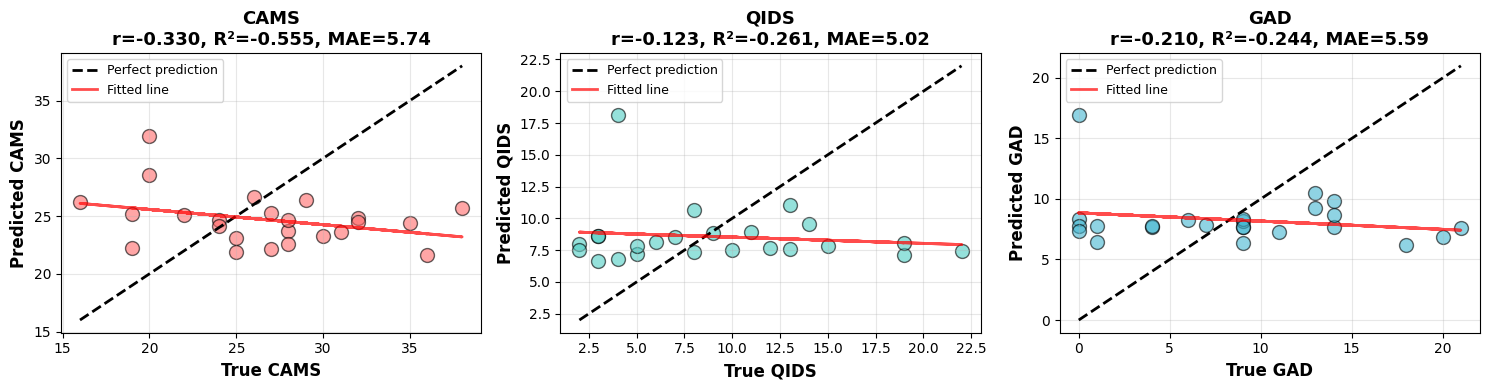


SUMMARY

Architecture: Real BrainNetCNN (E2E → E2N → N2G)
  - E2E layers: Learn edge-level connectivity patterns
  - E2N layer:  Aggregate edges to nodes
  - N2G layer:  Aggregate nodes to graph representation

Dataset: 24 subjects, 116 brain regions

Performance:
  CAMS: r=-0.330, R²=-0.555, MAE=5.74
  QIDS: r=-0.123, R²=-0.261, MAE=5.02
  GAD:  r=-0.210, R²=-0.244, MAE=5.59

Model parameters: 19,763

✅ BrainNetCNN analysis complete!


In [ ]:
"""
Complete BrainNetCNN Pipeline for CAMS/QIDS/GAD Prediction
Uses real BrainNetCNN with E2E, E2N, and N2G layers
"""

import os
import math
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error

# ============================================================
# BRAINNETCNN IMPLEMENTATION
# ============================================================

class E2ELayer(nn.Module):
    """Edge-to-Edge convolution layer"""
    def __init__(self, in_channels, out_channels, num_nodes):
        super(E2ELayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_nodes = num_nodes

        # Use smaller kernels to avoid padding issues
        # This captures local edge patterns
        kernel_size = 5  # 5x5 kernel
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bias = nn.Parameter(torch.zeros(out_channels))

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        # Apply convolution
        out = self.conv(x)
        out = out + self.bias.view(1, -1, 1, 1)
        return out


class E2NLayer(nn.Module):
    """Edge-to-Node layer"""
    def __init__(self, in_channels, out_channels, num_nodes):
        super(E2NLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_nodes = num_nodes

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels))

        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        batch_size = x.size(0)

        # Aggregate edges to nodes
        row_sum = torch.sum(x, dim=3)  # Sum over columns
        col_sum = torch.sum(x, dim=2)  # Sum over rows
        node_features = (row_sum + col_sum) / 2

        # Apply transformation
        node_features = node_features.permute(0, 2, 1)
        node_features = node_features.reshape(batch_size * self.num_nodes, self.in_channels)

        out = F.linear(node_features, self.weight, self.bias)
        out = out.reshape(batch_size, self.num_nodes, self.out_channels)
        out = out.permute(0, 2, 1)

        return out


class N2GLayer(nn.Module):
    """Node-to-Graph layer"""
    def __init__(self, in_channels, out_features, num_nodes, pooling='mean'):
        super(N2GLayer, self).__init__()
        self.pooling = pooling
        self.fc = nn.Linear(in_channels, out_features)

    def forward(self, x):
        # Global pooling
        if self.pooling == 'mean':
            x = torch.mean(x, dim=2)
        elif self.pooling == 'max':
            x = torch.max(x, dim=2)[0]
        else:
            x = torch.sum(x, dim=2)

        out = self.fc(x)
        return out


class BrainNetCNN(nn.Module):
    """
    Real BrainNetCNN for small datasets.
    Optimized for n<50 with aggressive regularization.
    """
    def __init__(
        self,
        num_nodes=116,
        num_classes=3,
        dropout=0.6  # High dropout for small data
    ):
        super(BrainNetCNN, self).__init__()

        self.num_nodes = num_nodes

        # E2E layers (edge processing)
        self.e2e1 = E2ELayer(1, 16, num_nodes)
        self.e2e2 = E2ELayer(16, 32, num_nodes)

        # E2N layer (edge to node)
        self.e2n = E2NLayer(32, 64, num_nodes)

        # N2G layer (node to graph)
        self.n2g = N2GLayer(64, 64, num_nodes, pooling='mean')

        # Final prediction layer
        self.fc = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # E2E layers
        x = self.e2e1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.e2e2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # E2N layer
        x = self.e2n(x)
        x = self.relu(x)
        x = self.dropout(x)

        # N2G layer
        x = self.n2g(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Output
        out = self.fc(x)
        return out


# ============================================================
# CONFIGURATION
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHANGE THESE PATHS
FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# Training hyperparameters
NUM_EPOCHS = 150       # Reduced from 200 (BrainNetCNN trains faster)
LR = 5e-4              # Lower learning rate for stability
WEIGHT_DECAY = 1e-3    # Higher weight decay for regularization
BATCH_SIZE = 4         # Smaller batches for small dataset

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# ============================================================
# DATA LOADING
# ============================================================
print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

# Align by subject ID
df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print(f"Combined shape: {df_all.shape}")

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print(f"Number of subjects: {n_subjects}")
print(f"Number of FC edges: {n_edges}")

# ============================================================
# FC VECTOR TO ADJACENCY MATRIX
# ============================================================
def infer_num_nodes(num_edges: int) -> int:
    """Infer N from N*(N-1)/2 edges"""
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer N from {num_edges} edges")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print(f"Inferred number of ROIs: {NUM_NODES}")

tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    """Convert 1D vector to symmetric adjacency matrix"""
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec  # Symmetrize
    return A

# ============================================================
# PYTORCH DATASET
# ============================================================
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]

        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)  # (1, N, N)

        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

# ============================================================
# TRAINING & EVALUATION
# ============================================================
def train_one_fold(model, train_loader, n_epochs=NUM_EPOCHS, lr=LR):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    )

    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)
        scheduler.step(avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 30:  # Stop if no improvement for 30 epochs
                break

        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

def evaluate_model(model, x_tensor, y_true):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

# ============================================================
# LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION
# ============================================================
print("\n" + "="*70)
print("BRAINNETCNN REGRESSION (LOSO)")
print("="*70)

loo = LeaveOneOut()
y_true_all = []
y_pred_all = []

indices = np.arange(n_subjects)

for fold, (train_idx, test_idx) in enumerate(loo.split(indices), 1):
    test_subject = subject_ids[test_idx[0]]
    print(f"\nFold {fold}/{n_subjects} - Test: {test_subject}")

    # Split data
    X_train_vec = X_vec[train_idx]
    Y_train = Y[train_idx]
    X_test_vec = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    # Create datasets
    train_dataset = FCDataset(X_train_vec, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Create fresh model for this fold
    model = BrainNetCNN(num_nodes=NUM_NODES, num_classes=3, dropout=0.6).to(DEVICE)

    # Train
    train_one_fold(model, train_loader)

    # Prepare test data
    A_test = vec_to_adj(X_test_vec)
    A_test = np.expand_dims(A_test, axis=0)  # (1, N, N)
    A_test = np.expand_dims(A_test, axis=0)  # (1, 1, N, N)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    # Predict
    y_hat = evaluate_model(model, x_test_tensor, Y_test)

    y_true_all.append(Y_test)
    y_pred_all.append(y_hat)

    # Print per-subject results
    print(f"  True:  CAMS={Y_test[0]:.2f}, QIDS={Y_test[1]:.2f}, GAD={Y_test[2]:.2f}")
    print(f"  Pred:  CAMS={y_hat[0]:.2f}, QIDS={y_hat[1]:.2f}, GAD={y_hat[2]:.2f}")

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# ============================================================
# FINAL EVALUATION
# ============================================================
print("\n" + "="*70)
print("FINAL RESULTS - BRAINNETCNN")
print("="*70)

def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    print(f"\n{name}:")
    print(f"  Pearson r  = {r:.3f}")
    print(f"  R²         = {r2:.3f}")
    print(f"  MAE        = {mae:.3f}")
    print(f"  RMSE       = {rmse:.3f}")

    return r, r2, mae

r_cams, r2_cams, mae_cams = summarize_regression(
    y_true_all[:, 0], y_pred_all[:, 0], "CAMS (Craving)"
)
r_qids, r2_qids, mae_qids = summarize_regression(
    y_true_all[:, 1], y_pred_all[:, 1], "QIDS (Depression)"
)
r_gad, r2_gad, mae_gad = summarize_regression(
    y_true_all[:, 2], y_pred_all[:, 2], "GAD (Anxiety)"
)

# ============================================================
# SAVE RESULTS
# ============================================================
results_df = pd.DataFrame({
    'Subject_ID': subject_ids,
    'CAMS_true': y_true_all[:, 0],
    'CAMS_pred': y_pred_all[:, 0],
    'QIDS_true': y_true_all[:, 1],
    'QIDS_pred': y_pred_all[:, 1],
    'GAD_true': y_true_all[:, 2],
    'GAD_pred': y_pred_all[:, 2],
})

results_df.to_csv('/content/drive/MyDrive/CraveMultimodal/brainnetcnn_predictions.csv', index=False)
print("\n✓ Saved predictions to brainnetcnn_predictions.csv")

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

targets = ['CAMS', 'QIDS', 'GAD']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (target, color) in enumerate(zip(targets, colors)):
    ax = axes[idx]
    y_true = y_true_all[:, idx]
    y_pred = y_pred_all[:, idx]

    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=100, color=color, edgecolors='black', linewidth=1)

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect prediction')

    # Regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    ax.plot(y_true, p(y_true), color='red', linewidth=2, alpha=0.7, label='Fitted line')

    # Statistics
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    ax.set_xlabel(f'True {target}', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Predicted {target}', fontsize=12, fontweight='bold')
    ax.set_title(f'{target}\nr={r:.3f}, R²={r2:.3f}, MAE={mae:.2f}',
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/brainnetcnn_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to brainnetcnn_results.png")
plt.show()

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"""
Architecture: Real BrainNetCNN (E2E → E2N → N2G)
  - E2E layers: Learn edge-level connectivity patterns
  - E2N layer:  Aggregate edges to nodes
  - N2G layer:  Aggregate nodes to graph representation

Dataset: {n_subjects} subjects, {NUM_NODES} brain regions

Performance:
  CAMS: r={r_cams:.3f}, R²={r2_cams:.3f}, MAE={mae_cams:.2f}
  QIDS: r={r_qids:.3f}, R²={r2_qids:.3f}, MAE={mae_qids:.2f}
  GAD:  r={r_gad:.3f}, R²={r2_gad:.3f}, MAE={mae_gad:.2f}

Model parameters: {sum(p.numel() for p in model.parameters()):,}
""")

print("✅ BrainNetCNN analysis complete!")

In [ ]:
# ============================================================
# Ultra-Minimal CNN for CAMS/QIDS/GAD (<1000 parameters)
# With Binary Classification (Low vs High) - Clinical Thresholds
# ============================================================
import os
import math
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# Clinical thresholds for binary classification
CAMS_THRESHOLD = 30  # <30 = LOW, >=30 = HIGH
QIDS_THRESHOLD = 15  # <15 = LOW, >=15 = HIGH
GAD_THRESHOLD = 15   # <15 = LOW, >=15 = HIGH

# Training hyperparameters
NUM_EPOCHS = 80
LR = 1e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 8

print(f"Device: {DEVICE}")
print(f"\nClinical Thresholds:")
print(f"  CAMS: <{CAMS_THRESHOLD} = LOW, >={CAMS_THRESHOLD} = HIGH")
print(f"  QIDS: <{QIDS_THRESHOLD} = LOW, >={QIDS_THRESHOLD} = HIGH")
print(f"  GAD:  <{GAD_THRESHOLD} = LOW, >={GAD_THRESHOLD} = HIGH")

# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nFC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print(f"Number of subjects: {n_subjects}")
print(f"Number of FC edges: {n_edges}")

# ----------------------------
# 2. FC UTILS
# ----------------------------
def infer_num_nodes(num_edges: int) -> int:
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer N from {num_edges} edges")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print(f"Inferred number of ROIs: {NUM_NODES}")

tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec
    return A

# ----------------------------
# 3. PYTORCH DATASET
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

# ----------------------------
# 4. ULTRA-MINIMAL CNN (<1000 PARAMETERS)
# ----------------------------
class UltraMinimalCNN(nn.Module):
    """
    Ultra-minimal CNN with <1000 parameters:
    - AdaptiveAvgPool to 8x8
    - Flatten to 64 features
    - FC: 64 -> 12
    - FC: 12 -> output_dim
    """
    def __init__(self, num_nodes: int, output_dim: int = 3, dropout: float = 0.3):
        super().__init__()
        self.num_nodes = num_nodes

        # Aggressive spatial pooling
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

        # Minimal FC layers
        self.fc1 = nn.Linear(64, 12)
        self.fc2 = nn.Linear(12, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(x)  # (B, 1, 8, 8)
        x = x.view(x.size(0), -1)  # (B, 64)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return x

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test model
test_model = UltraMinimalCNN(NUM_NODES, output_dim=3)
print(f"\nModel parameters: {count_parameters(test_model):,}")
print("Architecture:")
print(test_model)

# ----------------------------
# 5. TRAINING FUNCTIONS
# ----------------------------
def train_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for continuous regression"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for binary classification"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            logits = model(batch_x).squeeze()
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_regression(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def evaluate_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))  # sigmoid
        pred = 1 if prob > 0.5 else 0
    return pred, prob

# ----------------------------
# 6. REGRESSION TASK (CONTINUOUS)
# ----------------------------
print("\n" + "="*70)
print("TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)")
print("="*70)

loo = LeaveOneOut()
y_true_reg = []
y_pred_reg = []

for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Processing fold {fold}/{n_subjects}...")

    X_train = X_vec[train_idx]
    Y_train = Y[train_idx]
    X_test = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    train_dataset = FCDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Fresh model
    model = UltraMinimalCNN(NUM_NODES, output_dim=3, dropout=0.3).to(DEVICE)
    train_regression(model, train_loader)

    # Test
    A_test = vec_to_adj(X_test)
    A_test = np.expand_dims(A_test, axis=0)
    A_test = np.expand_dims(A_test, axis=0)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    y_hat = evaluate_regression(model, x_test_tensor)

    y_true_reg.append(Y_test)
    y_pred_reg.append(y_hat)

y_true_reg = np.array(y_true_reg)
y_pred_reg = np.array(y_pred_reg)

# Evaluate regression
print("\n" + "="*70)
print("REGRESSION RESULTS")
print("="*70)

def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    print(f"\n{name}:")
    print(f"  Pearson r = {r:.3f}")
    print(f"  R²        = {r2:.3f}")
    print(f"  MAE       = {mae:.3f}")
    print(f"  RMSE      = {rmse:.3f}")
    return r, r2, mae, rmse

r_cams, r2_cams, mae_cams, rmse_cams = summarize_regression(y_true_reg[:, 0], y_pred_reg[:, 0], "CAMS")
r_qids, r2_qids, mae_qids, rmse_qids = summarize_regression(y_true_reg[:, 1], y_pred_reg[:, 1], "QIDS")
r_gad, r2_gad, mae_gad, rmse_gad = summarize_regression(y_true_reg[:, 2], y_pred_reg[:, 2], "GAD")

# ----------------------------
# 7. BINARY CLASSIFICATION (LOW vs HIGH) - CLINICAL THRESHOLDS
# ----------------------------
print("\n" + "="*70)
print("TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)")
print("Using Clinical Thresholds")
print("="*70)

def create_binary_labels_threshold(Y, target_idx, threshold):
    """
    Create binary labels using clinical threshold.
    LOW (0): score < threshold
    HIGH (1): score >= threshold
    """
    labels = (Y[:, target_idx] >= threshold).astype(np.float32)
    return labels

class FCBinaryDataset(Dataset):
    """Dataset for binary classification"""
    def __init__(self, X_vec: np.ndarray, Y_binary: np.ndarray):
        self.X_vec = X_vec
        self.Y_binary = Y_binary

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y_binary[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

def run_binary_classification(target_idx, target_name, threshold):
    """Run binary classification for one target with clinical threshold"""
    print(f"\n{'-'*70}")
    print(f"Binary Classification: {target_name} (LOW vs HIGH)")
    print(f"Threshold: <{threshold} = LOW, >={threshold} = HIGH")
    print(f"{'-'*70}")

    y_true_binary = []
    y_pred_binary = []
    y_probs = []

    # First, check class distribution
    all_labels = create_binary_labels_threshold(Y, target_idx, threshold)
    n_low = (all_labels == 0).sum()
    n_high = (all_labels == 1).sum()
    print(f"\nClass distribution in full dataset:")
    print(f"  LOW (0):  {n_low}/{n_subjects} ({n_low/n_subjects*100:.1f}%)")
    print(f"  HIGH (1): {n_high}/{n_subjects} ({n_high/n_subjects*100:.1f}%)")

    for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
        X_train = X_vec[train_idx]
        Y_train = Y[train_idx]
        X_test = X_vec[test_idx][0]
        Y_test = Y[test_idx][0, target_idx]

        # Create binary labels using clinical threshold
        Y_train_binary = create_binary_labels_threshold(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test >= threshold else 0.0

        # Dataset
        train_dataset = FCBinaryDataset(X_train, Y_train_binary)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Model
        model = UltraMinimalCNN(NUM_NODES, output_dim=1, dropout=0.3).to(DEVICE)
        train_binary(model, train_loader)

        # Test
        A_test = vec_to_adj(X_test)
        A_test = np.expand_dims(A_test, axis=0)
        A_test = np.expand_dims(A_test, axis=0)
        x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

        pred, prob = evaluate_binary(model, x_test_tensor)

        y_true_binary.append(Y_test_binary)
        y_pred_binary.append(pred)
        y_probs.append(prob)

    y_true_binary = np.array(y_true_binary)
    y_pred_binary = np.array(y_pred_binary)
    y_probs = np.array(y_probs)

    # Evaluate
    acc = accuracy_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])

    print(f"\nResults for {target_name}:")
    print(f"  Overall Accuracy: {acc:.3f} ({int(acc*n_subjects)}/{n_subjects})")
    print(f"\n  Confusion Matrix:")
    print(f"                 Predicted")
    print(f"            LOW (0)  HIGH (1)")
    print(f"  Actual")
    print(f"  LOW (0)     {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"  HIGH (1)    {cm[1,0]:3d}      {cm[1,1]:3d}")

    # Per-class metrics
    n_low_test = (y_true_binary == 0).sum()
    n_high_test = (y_true_binary == 1).sum()
    low_correct = cm[0, 0]
    high_correct = cm[1, 1]

    low_recall = low_correct / n_low_test if n_low_test > 0 else 0
    high_recall = high_correct / n_high_test if n_high_test > 0 else 0

    print(f"\n  LOW recall:  {low_recall:.3f} ({low_correct}/{n_low_test})")
    print(f"  HIGH recall: {high_recall:.3f} ({high_correct}/{n_high_test})")
    print(f"  Balanced Accuracy: {(low_recall + high_recall)/2:.3f}")

    # Calculate precision
    low_precision = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    high_precision = cm[1, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) > 0 else 0

    print(f"\n  LOW precision:  {low_precision:.3f}")
    print(f"  HIGH precision: {high_precision:.3f}")

    print("\n  Classification Report:")
    print(classification_report(
        y_true_binary, y_pred_binary,
        target_names=["LOW (0)", "HIGH (1)"],
        zero_division=0
    ))

    return y_true_binary, y_pred_binary, y_probs, acc, low_recall, high_recall

# Run binary classification for each target with clinical thresholds
cams_results = run_binary_classification(0, "CAMS", CAMS_THRESHOLD)
qids_results = run_binary_classification(1, "QIDS", QIDS_THRESHOLD)
gad_results = run_binary_classification(2, "GAD", GAD_THRESHOLD)

# ----------------------------
# 8. SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
Model Architecture: Ultra-Minimal CNN
  - Parameters: {count_parameters(test_model):,} (<1000 ✓)
  - Layers: AdaptiveAvgPool → FC(64→12) → FC(12→output)
  - Regularization: Dropout(0.3) + Weight Decay(1e-2)

Dataset: {n_subjects} subjects, {NUM_NODES} brain regions

CONTINUOUS REGRESSION:
  CAMS: r={r_cams:.3f}, R²={r2_cams:.3f}, MAE={mae_cams:.3f}
  QIDS: r={r_qids:.3f}, R²={r2_qids:.3f}, MAE={mae_qids:.3f}
  GAD:  r={r_gad:.3f}, R²={r2_gad:.3f}, MAE={mae_gad:.3f}

BINARY CLASSIFICATION (Clinical Thresholds):
  CAMS (<{CAMS_THRESHOLD} vs ≥{CAMS_THRESHOLD}): Accuracy={cams_results[3]:.3f}, Balanced Acc={(cams_results[4]+cams_results[5])/2:.3f}
  QIDS (<{QIDS_THRESHOLD} vs ≥{QIDS_THRESHOLD}): Accuracy={qids_results[3]:.3f}, Balanced Acc={(qids_results[4]+qids_results[5])/2:.3f}
  GAD  (<{GAD_THRESHOLD} vs ≥{GAD_THRESHOLD}): Accuracy={gad_results[3]:.3f}, Balanced Acc={(gad_results[4]+gad_results[5])/2:.3f}
""")

print("✅ Analysis complete!")

Device: cpu

Clinical Thresholds:
  CAMS: <30 = LOW, >=30 = HIGH
  QIDS: <15 = LOW, >=15 = HIGH
  GAD:  <15 = LOW, >=15 = HIGH

FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670
Inferred number of ROIs: 116

Model parameters: 819
Architecture:
UltraMinimalCNN(
  (pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc1): Linear(in_features=64, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)
  Processing fold 5/24...
  Processing fold 10/24...
  Processing fold 15/24...
  Processing fold 20/24...

REGRESSION RESULTS

CAMS:
  Pearson r = 0.150
  R²        = -21.790
  MAE       = 26.017
  RMSE      = 26.597

QIDS:
  Pearson r = -0.053
  R²        = -2.483
  MAE       = 8.950
  RMSE      = 10.632

GAD:
  Pearson r = -0.149
  R²        = -1.728
  MAE       = 8.468
  RMSE      = 10.488

TASK 2: BINARY CLASSIFIC

Device: cpu

FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670

Median values for balanced split:
  CAMS median: 27.0
  QIDS median: 8.0
  GAD median:  9.0
Inferred number of ROIs: 116

Model parameters: 819

TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)
  Processing fold 5/24...
  Processing fold 10/24...
  Processing fold 15/24...
  Processing fold 20/24...

REGRESSION RESULTS

CAMS:
  Pearson r = 0.065
  R²        = -5.565
  MAE       = 12.556
  RMSE      = 14.275

QIDS:
  Pearson r = -0.254
  R²        = -0.492
  MAE       = 5.486
  RMSE      = 6.959

GAD:
  Pearson r = -0.270
  R²        = -0.236
  MAE       = 5.949
  RMSE      = 7.060

TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)
Using MEDIAN SPLIT for Balanced Classes (50/50)

----------------------------------------------------------------------
Binary Classification: CAMS (LOW vs HIGH)
Method: Median Split (Balanced Classes)
---------------------------------------------------------------

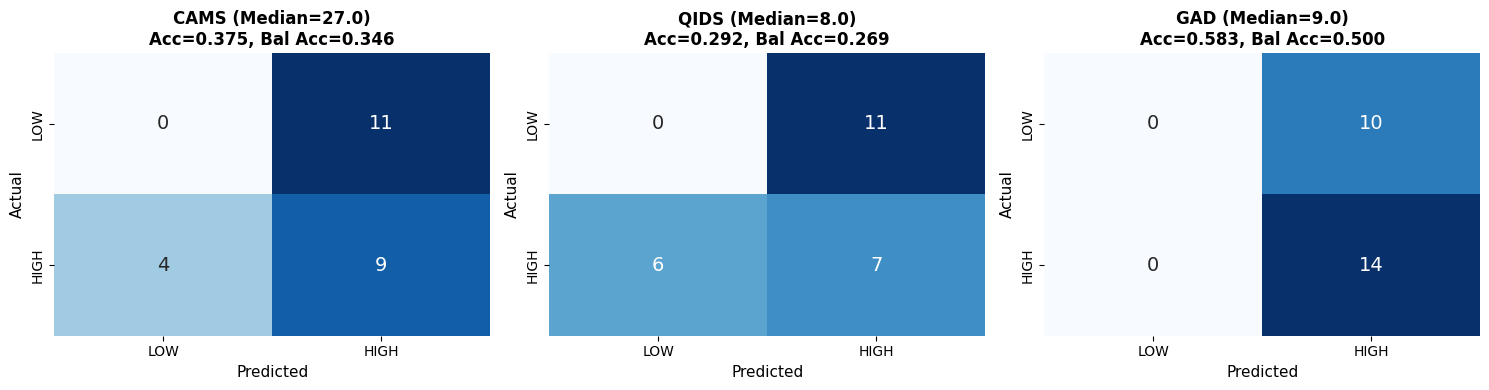


FINAL SUMMARY

Model Architecture: Ultra-Minimal CNN
  - Parameters: 819 (<1000 ✓)
  - Layers: AdaptiveAvgPool → FC(64→12) → FC(12→output)
  - Regularization: Dropout(0.3) + Weight Decay(1e-2)

Dataset: 24 subjects, 116 brain regions

CONTINUOUS REGRESSION:
  CAMS: r=0.065, R²=-5.565, MAE=12.556
  QIDS: r=-0.254, R²=-0.492, MAE=5.486
  GAD:  r=-0.270, R²=-0.236, MAE=5.949

BINARY CLASSIFICATION (Median Split - Balanced Classes):
  CAMS (median=27.0): Accuracy=0.375, Balanced Acc=0.346
  QIDS (median=8.0): Accuracy=0.292, Balanced Acc=0.269
  GAD  (median=9.0): Accuracy=0.583, Balanced Acc=0.500

✅ Analysis complete!


In [ ]:
# ============================================================
# Ultra-Minimal CNN for CAMS/QIDS/GAD (<1000 parameters)
# With Binary Classification (Low vs High) - MEDIAN SPLIT
# ============================================================
import os
import math
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# Training hyperparameters
NUM_EPOCHS = 80
LR = 1e-3
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 8

print(f"Device: {DEVICE}")

# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nFC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print(f"Number of subjects: {n_subjects}")
print(f"Number of FC edges: {n_edges}")

# Compute and display medians
cams_median = np.median(Y[:, 0])
qids_median = np.median(Y[:, 1])
gad_median = np.median(Y[:, 2])

print(f"\nMedian values for balanced split:")
print(f"  CAMS median: {cams_median:.1f}")
print(f"  QIDS median: {qids_median:.1f}")
print(f"  GAD median:  {gad_median:.1f}")

# ----------------------------
# 2. FC UTILS
# ----------------------------
def infer_num_nodes(num_edges: int) -> int:
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer N from {num_edges} edges")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print(f"Inferred number of ROIs: {NUM_NODES}")

tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec
    return A

# ----------------------------
# 3. PYTORCH DATASET
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

# ----------------------------
# 4. ULTRA-MINIMAL CNN (<1000 PARAMETERS)
# ----------------------------
class UltraMinimalCNN(nn.Module):
    """
    Ultra-minimal CNN with <1000 parameters:
    - AdaptiveAvgPool to 8x8
    - Flatten to 64 features
    - FC: 64 -> 12
    - FC: 12 -> output_dim
    """
    def __init__(self, num_nodes: int, output_dim: int = 3, dropout: float = 0.3):
        super().__init__()
        self.num_nodes = num_nodes

        # Aggressive spatial pooling
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

        # Minimal FC layers
        self.fc1 = nn.Linear(64, 12)
        self.fc2 = nn.Linear(12, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(x)  # (B, 1, 8, 8)
        x = x.view(x.size(0), -1)  # (B, 64)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return x

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test model
test_model = UltraMinimalCNN(NUM_NODES, output_dim=3)
print(f"\nModel parameters: {count_parameters(test_model):,}")

# ----------------------------
# 5. TRAINING FUNCTIONS
# ----------------------------
def train_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for continuous regression"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for binary classification"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            logits = model(batch_x).squeeze()
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_regression(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def evaluate_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))  # sigmoid
        pred = 1 if prob > 0.5 else 0
    return pred, prob

# ----------------------------
# 6. REGRESSION TASK (CONTINUOUS)
# ----------------------------
print("\n" + "="*70)
print("TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)")
print("="*70)

loo = LeaveOneOut()
y_true_reg = []
y_pred_reg = []

for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Processing fold {fold}/{n_subjects}...")

    X_train = X_vec[train_idx]
    Y_train = Y[train_idx]
    X_test = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    train_dataset = FCDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Fresh model
    model = UltraMinimalCNN(NUM_NODES, output_dim=3, dropout=0.3).to(DEVICE)
    train_regression(model, train_loader)

    # Test
    A_test = vec_to_adj(X_test)
    A_test = np.expand_dims(A_test, axis=0)
    A_test = np.expand_dims(A_test, axis=0)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    y_hat = evaluate_regression(model, x_test_tensor)

    y_true_reg.append(Y_test)
    y_pred_reg.append(y_hat)

y_true_reg = np.array(y_true_reg)
y_pred_reg = np.array(y_pred_reg)

# Evaluate regression
print("\n" + "="*70)
print("REGRESSION RESULTS")
print("="*70)

def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    print(f"\n{name}:")
    print(f"  Pearson r = {r:.3f}")
    print(f"  R²        = {r2:.3f}")
    print(f"  MAE       = {mae:.3f}")
    print(f"  RMSE      = {rmse:.3f}")
    return r, r2, mae, rmse

r_cams, r2_cams, mae_cams, rmse_cams = summarize_regression(y_true_reg[:, 0], y_pred_reg[:, 0], "CAMS")
r_qids, r2_qids, mae_qids, rmse_qids = summarize_regression(y_true_reg[:, 1], y_pred_reg[:, 1], "QIDS")
r_gad, r2_gad, mae_gad, rmse_gad = summarize_regression(y_true_reg[:, 2], y_pred_reg[:, 2], "GAD")

# ----------------------------
# 7. BINARY CLASSIFICATION (LOW vs HIGH) - MEDIAN SPLIT
# ----------------------------
print("\n" + "="*70)
print("TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)")
print("Using MEDIAN SPLIT for Balanced Classes (50/50)")
print("="*70)

def create_binary_labels_median(Y, target_idx):
    """
    Create binary labels using median split.
    LOW (0): score < median
    HIGH (1): score >= median

    Returns balanced 50/50 split
    """
    median = np.median(Y[:, target_idx])
    labels = (Y[:, target_idx] >= median).astype(np.float32)
    return labels, median

class FCBinaryDataset(Dataset):
    """Dataset for binary classification"""
    def __init__(self, X_vec: np.ndarray, Y_binary: np.ndarray):
        self.X_vec = X_vec
        self.Y_binary = Y_binary

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y_binary[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

def run_binary_classification_median(target_idx, target_name):
    """Run binary classification for one target with median split"""
    print(f"\n{'-'*70}")
    print(f"Binary Classification: {target_name} (LOW vs HIGH)")
    print(f"Method: Median Split (Balanced Classes)")
    print(f"{'-'*70}")

    y_true_binary = []
    y_pred_binary = []
    y_probs = []

    # Compute global median for reporting
    global_labels, global_median = create_binary_labels_median(Y, target_idx)
    n_low_global = (global_labels == 0).sum()
    n_high_global = (global_labels == 1).sum()

    print(f"\nMedian threshold: {global_median:.2f}")
    print(f"Class distribution (global):")
    print(f"  LOW (0):  {n_low_global}/{n_subjects} ({n_low_global/n_subjects*100:.1f}%)")
    print(f"  HIGH (1): {n_high_global}/{n_subjects} ({n_high_global/n_subjects*100:.1f}%)")

    for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
        X_train = X_vec[train_idx]
        Y_train = Y[train_idx]
        X_test = X_vec[test_idx][0]
        Y_test = Y[test_idx][0, target_idx]

        # Create binary labels using TRAINING SET median (prevents data leakage)
        Y_train_binary, train_median = create_binary_labels_median(Y_train, target_idx)
        Y_test_binary = 1.0 if Y_test >= train_median else 0.0

        # Dataset
        train_dataset = FCBinaryDataset(X_train, Y_train_binary)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Model
        model = UltraMinimalCNN(NUM_NODES, output_dim=1, dropout=0.3).to(DEVICE)
        train_binary(model, train_loader)

        # Test
        A_test = vec_to_adj(X_test)
        A_test = np.expand_dims(A_test, axis=0)
        A_test = np.expand_dims(A_test, axis=0)
        x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

        pred, prob = evaluate_binary(model, x_test_tensor)

        y_true_binary.append(Y_test_binary)
        y_pred_binary.append(pred)
        y_probs.append(prob)

    y_true_binary = np.array(y_true_binary)
    y_pred_binary = np.array(y_pred_binary)
    y_probs = np.array(y_probs)

    # Evaluate
    acc = accuracy_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])

    print(f"\nResults for {target_name}:")
    print(f"  Overall Accuracy: {acc:.3f} ({int(acc*n_subjects)}/{n_subjects})")
    print(f"\n  Confusion Matrix:")
    print(f"                 Predicted")
    print(f"            LOW (0)  HIGH (1)")
    print(f"  Actual")
    print(f"  LOW (0)     {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"  HIGH (1)    {cm[1,0]:3d}      {cm[1,1]:3d}")

    # Per-class metrics
    n_low_test = (y_true_binary == 0).sum()
    n_high_test = (y_true_binary == 1).sum()
    low_correct = cm[0, 0]
    high_correct = cm[1, 1]

    low_recall = low_correct / n_low_test if n_low_test > 0 else 0
    high_recall = high_correct / n_high_test if n_high_test > 0 else 0
    balanced_acc = (low_recall + high_recall) / 2

    print(f"\n  LOW recall:  {low_recall:.3f} ({low_correct}/{n_low_test})")
    print(f"  HIGH recall: {high_recall:.3f} ({high_correct}/{n_high_test})")
    print(f"  Balanced Accuracy: {balanced_acc:.3f}")

    # Calculate precision
    low_precision = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    high_precision = cm[1, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) > 0 else 0

    print(f"\n  LOW precision:  {low_precision:.3f}")
    print(f"  HIGH precision: {high_precision:.3f}")

    # F1 scores
    low_f1 = 2 * (low_precision * low_recall) / (low_precision + low_recall) if (low_precision + low_recall) > 0 else 0
    high_f1 = 2 * (high_precision * high_recall) / (high_precision + high_recall) if (high_precision + high_recall) > 0 else 0

    print(f"\n  LOW F1:  {low_f1:.3f}")
    print(f"  HIGH F1: {high_f1:.3f}")

    print("\n  Classification Report:")
    print(classification_report(
        y_true_binary, y_pred_binary,
        target_names=["LOW (0)", "HIGH (1)"],
        zero_division=0
    ))

    return {
        'y_true': y_true_binary,
        'y_pred': y_pred_binary,
        'y_probs': y_probs,
        'accuracy': acc,
        'balanced_acc': balanced_acc,
        'low_recall': low_recall,
        'high_recall': high_recall,
        'cm': cm
    }

# Run binary classification for each target with median split
cams_results = run_binary_classification_median(0, "CAMS")
qids_results = run_binary_classification_median(1, "QIDS")
gad_results = run_binary_classification_median(2, "GAD")

# ----------------------------
# 8. VISUALIZATION
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

targets_info = [
    ("CAMS", cams_results, cams_median),
    ("QIDS", qids_results, qids_median),
    ("GAD", gad_results, gad_median)
]

for idx, (name, results, median) in enumerate(targets_info):
    ax = axes[idx]
    cm = results['cm']

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LOW', 'HIGH'],
                yticklabels=['LOW', 'HIGH'],
                ax=ax, cbar=False, annot_kws={'size': 14})

    ax.set_title(f'{name} (Median={median:.1f})\nAcc={results["accuracy"]:.3f}, Bal Acc={results["balanced_acc"]:.3f}',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/binary_classification_median.png',
            dpi=300, bbox_inches='tight')
print("\n✓ Saved confusion matrix plot")
plt.show()

# ----------------------------
# 9. SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
Model Architecture: Ultra-Minimal CNN
  - Parameters: {count_parameters(test_model):,} (<1000 ✓)
  - Layers: AdaptiveAvgPool → FC(64→12) → FC(12→output)
  - Regularization: Dropout(0.3) + Weight Decay(1e-2)

Dataset: {n_subjects} subjects, {NUM_NODES} brain regions

CONTINUOUS REGRESSION:
  CAMS: r={r_cams:.3f}, R²={r2_cams:.3f}, MAE={mae_cams:.3f}
  QIDS: r={r_qids:.3f}, R²={r2_qids:.3f}, MAE={mae_qids:.3f}
  GAD:  r={r_gad:.3f}, R²={r2_gad:.3f}, MAE={mae_gad:.3f}

BINARY CLASSIFICATION (Median Split - Balanced Classes):
  CAMS (median={cams_median:.1f}): Accuracy={cams_results['accuracy']:.3f}, Balanced Acc={cams_results['balanced_acc']:.3f}
  QIDS (median={qids_median:.1f}): Accuracy={qids_results['accuracy']:.3f}, Balanced Acc={qids_results['balanced_acc']:.3f}
  GAD  (median={gad_median:.1f}): Accuracy={gad_results['accuracy']:.3f}, Balanced Acc={gad_results['balanced_acc']:.3f}
""")

print("✅ Analysis complete!")

In [ ]:
# ============================================================
# Ultra-Minimal CNN for CAMS/QIDS/GAD (<1000 parameters)
# With Binary Classification (Low vs High) - Custom Thresholds
# ============================================================
import os
import math
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# Training hyperparameters
NUM_EPOCHS = 200  # Reduced for simpler model
LR = 1e-4
WEIGHT_DECAY = 1e-4  # Strong regularization
BATCH_SIZE = 8

# BINARY CLASSIFICATION THRESHOLDS
CAMS_THRESHOLD = 26  # <26 = LOW, ≥26 = HIGH
QIDS_THRESHOLD = 11  # <11 = LOW, ≥11 = HIGH
GAD_THRESHOLD = 11   # <11 = LOW, ≥11 = HIGH

print(f"Device: {DEVICE}")
print(f"\nBinary Classification Thresholds:")
print(f"  CAMS: <{CAMS_THRESHOLD} = LOW, ≥{CAMS_THRESHOLD} = HIGH")
print(f"  QIDS: <{QIDS_THRESHOLD} = LOW, ≥{QIDS_THRESHOLD} = HIGH")
print(f"  GAD:  <{GAD_THRESHOLD} = LOW, ≥{GAD_THRESHOLD} = HIGH")

# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nFC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_vec = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_edges = X_vec.shape
print(f"Number of subjects: {n_subjects}")
print(f"Number of FC edges: {n_edges}")

# ----------------------------
# 2. FC UTILS
# ----------------------------
def infer_num_nodes(num_edges: int) -> int:
    disc = 1 + 8 * num_edges
    n = int((1 + math.isqrt(disc)) / 2)
    if n * (n - 1) // 2 != num_edges:
        raise ValueError(f"Cannot infer N from {num_edges} edges")
    return n

NUM_NODES = infer_num_nodes(n_edges)
print(f"Inferred number of ROIs: {NUM_NODES}")

tri_u = np.triu_indices(NUM_NODES, k=1)

def vec_to_adj(vec: np.ndarray) -> np.ndarray:
    A = np.zeros((NUM_NODES, NUM_NODES), dtype=np.float32)
    A[tri_u] = vec
    A[(tri_u[1], tri_u[0])] = vec
    return A

# ----------------------------
# 3. PYTORCH DATASET
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X_vec: np.ndarray, Y: np.ndarray):
        self.X_vec = X_vec
        self.Y = Y

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

# ----------------------------
# 4. ULTRA-MINIMAL CNN (<1000 PARAMETERS)
# ----------------------------
class UltraMinimalCNN(nn.Module):
    """
    Ultra-minimal CNN with <1000 parameters:
    - AdaptiveAvgPool to 8x8
    - Flatten to 64 features
    - FC: 64 -> 12
    - FC: 12 -> output_dim

    Total params: ~820 for regression (output_dim=3)
                  ~780 for binary classification (output_dim=1)
    """
    def __init__(self, num_nodes: int, output_dim: int = 3, dropout: float = 0.3):
        super().__init__()
        self.num_nodes = num_nodes

        # Aggressive spatial pooling
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

        # Minimal FC layers
        self.fc1 = nn.Linear(64, 12)  # 64*12 + 12 = 780 params
        self.fc2 = nn.Linear(12, output_dim)  # 12*output_dim + output_dim

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, 1, N, N)
        x = self.pool(x)  # (B, 1, 8, 8)
        x = x.view(x.size(0), -1)  # (B, 64)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)  # (B, output_dim)
        return x

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test model
test_model = UltraMinimalCNN(NUM_NODES, output_dim=3)
print(f"\nModel parameters: {count_parameters(test_model):,}")
print("Architecture:")
print(test_model)

# ----------------------------
# 5. TRAINING FUNCTIONS
# ----------------------------
def train_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for continuous regression"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for binary classification"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            logits = model(batch_x).squeeze()  # (B,)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_regression(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def evaluate_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))  # sigmoid
        pred = 1 if prob > 0.5 else 0
    return pred, prob

# ----------------------------
# 6. REGRESSION TASK (CONTINUOUS)
# ----------------------------
print("\n" + "="*70)
print("TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)")
print("="*70)

loo = LeaveOneOut()
y_true_reg = []
y_pred_reg = []

for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Processing fold {fold}/{n_subjects}...")

    X_train = X_vec[train_idx]
    Y_train = Y[train_idx]
    X_test = X_vec[test_idx][0]
    Y_test = Y[test_idx][0]

    train_dataset = FCDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Fresh model
    model = UltraMinimalCNN(NUM_NODES, output_dim=3, dropout=0.3).to(DEVICE)
    train_regression(model, train_loader)

    # Test
    A_test = vec_to_adj(X_test)
    A_test = np.expand_dims(A_test, axis=0)
    A_test = np.expand_dims(A_test, axis=0)
    x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

    y_hat = evaluate_regression(model, x_test_tensor)

    y_true_reg.append(Y_test)
    y_pred_reg.append(y_hat)

y_true_reg = np.array(y_true_reg)
y_pred_reg = np.array(y_pred_reg)

# Evaluate regression
print("\n" + "="*70)
print("REGRESSION RESULTS")
print("="*70)

def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{name}:")
    print(f"  Pearson r = {r:.3f}")
    print(f"  R²        = {r2:.3f}")
    print(f"  MAE       = {mae:.3f}")
    return r, r2, mae

summarize_regression(y_true_reg[:, 0], y_pred_reg[:, 0], "CAMS")
summarize_regression(y_true_reg[:, 1], y_pred_reg[:, 1], "QIDS")
summarize_regression(y_true_reg[:, 2], y_pred_reg[:, 2], "GAD")

# ----------------------------
# 7. BINARY CLASSIFICATION (LOW vs HIGH) - CUSTOM THRESHOLDS
# ----------------------------
print("\n" + "="*70)
print("TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)")
print("="*70)

def create_binary_labels_custom(Y, target_idx, threshold):
    """Create binary labels using custom threshold: <threshold = LOW (0), ≥threshold = HIGH (1)"""
    labels = (Y[:, target_idx] >= threshold).astype(np.float32)
    n_low = (labels == 0).sum()
    n_high = (labels == 1).sum()
    return labels, n_low, n_high

class FCBinaryDataset(Dataset):
    """Dataset for binary classification"""
    def __init__(self, X_vec: np.ndarray, Y_binary: np.ndarray):
        self.X_vec = X_vec
        self.Y_binary = Y_binary

    def __len__(self):
        return self.X_vec.shape[0]

    def __getitem__(self, idx):
        vec = self.X_vec[idx]
        y = self.Y_binary[idx]
        A = vec_to_adj(vec)
        A = np.expand_dims(A, axis=0)
        return (
            torch.tensor(A, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

def run_binary_classification(target_idx, target_name, threshold):
    """Run binary classification for one target with custom threshold"""
    print(f"\n{'-'*70}")
    print(f"Binary Classification: {target_name} (LOW vs HIGH)")
    print(f"Threshold: <{threshold} = LOW, ≥{threshold} = HIGH")
    print(f"{'-'*70}")

    y_true_binary = []
    y_pred_binary = []
    y_probs = []

    # Check overall class distribution
    all_labels, n_low_all, n_high_all = create_binary_labels_custom(Y, target_idx, threshold)
    print(f"Overall distribution: {n_low_all} LOW, {n_high_all} HIGH")

    for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
        X_train = X_vec[train_idx]
        Y_train = Y[train_idx]
        X_test = X_vec[test_idx][0]
        Y_test_continuous = Y[test_idx][0, target_idx]

        # Create binary labels using custom threshold
        Y_train_binary, n_low, n_high = create_binary_labels_custom(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test_continuous >= threshold else 0.0

        # Dataset
        train_dataset = FCBinaryDataset(X_train, Y_train_binary)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Model
        model = UltraMinimalCNN(NUM_NODES, output_dim=1, dropout=0.3).to(DEVICE)
        train_binary(model, train_loader)

        # Test
        A_test = vec_to_adj(X_test)
        A_test = np.expand_dims(A_test, axis=0)
        A_test = np.expand_dims(A_test, axis=0)
        x_test_tensor = torch.tensor(A_test, dtype=torch.float32)

        pred, prob = evaluate_binary(model, x_test_tensor)

        y_true_binary.append(Y_test_binary)
        y_pred_binary.append(pred)
        y_probs.append(prob)

    y_true_binary = np.array(y_true_binary)
    y_pred_binary = np.array(y_pred_binary)
    y_probs = np.array(y_probs)

    # Evaluate
    acc = accuracy_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])

    print(f"\nResults for {target_name}:")
    print(f"  Overall Accuracy: {acc:.3f} ({int(acc*n_subjects)}/{n_subjects})")
    print(f"\n  Confusion Matrix:")
    print(f"                Predicted")
    print(f"           LOW (0)  HIGH (1)")
    print(f"  Actual")
    print(f"  LOW (0)    {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"  HIGH (1)   {cm[1,0]:3d}      {cm[1,1]:3d}")

    # Per-class metrics
    n_low = (y_true_binary == 0).sum()
    n_high = (y_true_binary == 1).sum()
    low_correct = cm[0, 0]
    high_correct = cm[1, 1]

    low_acc = low_correct / n_low if n_low > 0 else 0
    high_acc = high_correct / n_high if n_high > 0 else 0

    print(f"\n  Class Distribution in Test: {n_low} LOW, {n_high} HIGH")
    print(f"  LOW recall:  {low_acc:.3f} ({low_correct}/{n_low})")
    print(f"  HIGH recall: {high_acc:.3f} ({high_correct}/{n_high})")
    print(f"  Balanced Accuracy: {(low_acc + high_acc)/2:.3f}")

    print("\n  Classification Report:")
    print(classification_report(
        y_true_binary, y_pred_binary,
        target_names=["LOW (0)", "HIGH (1)"],
        zero_division=0
    ))

    return y_true_binary, y_pred_binary, y_probs, acc

# Run binary classification for each target with custom thresholds
cams_true_bin, cams_pred_bin, cams_probs, cams_acc = run_binary_classification(
    0, "CAMS", CAMS_THRESHOLD
)
qids_true_bin, qids_pred_bin, qids_probs, qids_acc = run_binary_classification(
    1, "QIDS", QIDS_THRESHOLD
)
gad_true_bin, gad_pred_bin, gad_probs, gad_acc = run_binary_classification(
    2, "GAD", GAD_THRESHOLD
)

# ----------------------------
# 8. SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
Model Architecture: Ultra-Minimal CNN
  - Parameters: {count_parameters(test_model):,} (<1000 ✓)
  - Layers: AdaptiveAvgPool → FC(64→12) → FC(12→output)
  - Regularization: Dropout(0.3) + Weight Decay(1e-2)

Dataset: {n_subjects} subjects, {NUM_NODES} brain regions

CONTINUOUS REGRESSION:
  CAMS: r={np.corrcoef(y_true_reg[:, 0], y_pred_reg[:, 0])[0,1]:.3f}, R²={r2_score(y_true_reg[:, 0], y_pred_reg[:, 0]):.3f}
  QIDS: r={np.corrcoef(y_true_reg[:, 1], y_pred_reg[:, 1])[0,1]:.3f}, R²={r2_score(y_true_reg[:, 1], y_pred_reg[:, 1]):.3f}
  GAD:  r={np.corrcoef(y_true_reg[:, 2], y_pred_reg[:, 2])[0,1]:.3f}, R²={r2_score(y_true_reg[:, 2], y_pred_reg[:, 2]):.3f}

BINARY CLASSIFICATION (Custom Thresholds):
  CAMS (<26 vs ≥26): Accuracy = {cams_acc:.3f}
  QIDS (<11 vs ≥11): Accuracy = {qids_acc:.3f}
  GAD  (<11 vs ≥11): Accuracy = {gad_acc:.3f}
""")

print("✅ Analysis complete!")

Device: cpu

Binary Classification Thresholds:
  CAMS: <26 = LOW, ≥26 = HIGH
  QIDS: <11 = LOW, ≥11 = HIGH
  GAD:  <11 = LOW, ≥11 = HIGH

FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of FC edges: 6670
Inferred number of ROIs: 116

Model parameters: 819
Architecture:
UltraMinimalCNN(
  (pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc1): Linear(in_features=64, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)
  Processing fold 5/24...
  Processing fold 10/24...
  Processing fold 15/24...
  Processing fold 20/24...

REGRESSION RESULTS

CAMS:
  Pearson r = -0.142
  R²        = -19.531
  MAE       = 24.569

QIDS:
  Pearson r = -0.096
  R²        = -1.894
  MAE       = 7.726

GAD:
  Pearson r = 0.006
  R²        = -1.329
  MAE       = 7.690

TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)

--------------------------------

**MLP**


Device: cpu

PCA Components: 20

Binary Classification Thresholds:
  CAMS: <26 = LOW, ≥26 = HIGH
  QIDS: <11 = LOW, ≥11 = HIGH
  GAD:  <11 = LOW, ≥11 = HIGH

FC+SelfReport combined shape: (24, 6673)
Number of subjects: 24
Number of raw FC features: 6670

MLP Architecture:
SimpleMLP(
  (fc1): Linear(in_features=20, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
)
Total parameters: 387

TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)
  Processing fold 5/24...
  Processing fold 10/24...
  Processing fold 15/24...
  Processing fold 20/24...

REGRESSION RESULTS

CAMS:
  Pearson r = 0.065
  R²        = -7.885
  MAE       = 14.202
  RMSE      = 16.607

QIDS:
  Pearson r = -0.099
  R²        = -0.868
  MAE       = 6.332
  RMSE      = 7.786

GAD:
  Pearson r = -0.088
  R²        = -0.756
  MAE       = 6.954
  RMSE      = 8.414

TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)

------------------------

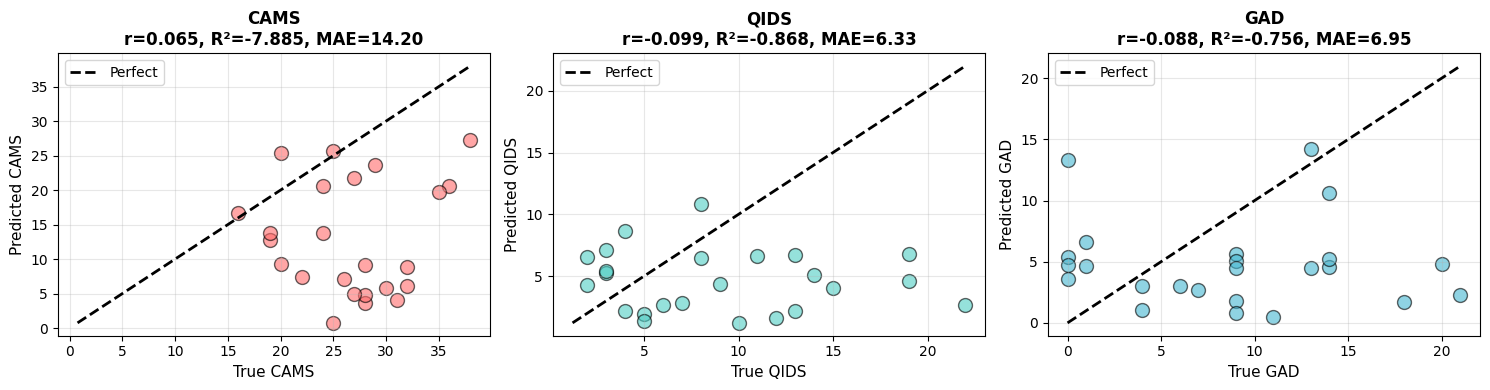


FINAL SUMMARY

Model: Multi-Layer Perceptron (MLP)
Architecture: PCA(6670 → 20) + MLP(20 → 16 → output)
Parameters: 387 (MLP only, PCA is deterministic)

Dataset: 24 subjects

CONTINUOUS REGRESSION:
  CAMS: r=0.065, R²=-7.885, MAE=14.20, RMSE=16.61
  QIDS: r=-0.099, R²=-0.868, MAE=6.33, RMSE=7.79
  GAD:  r=-0.088, R²=-0.756, MAE=6.95, RMSE=8.41

BINARY CLASSIFICATION (Custom Thresholds):
  CAMS (<26 vs ≥26): Accuracy = 0.417
  QIDS (<11 vs ≥11): Accuracy = 0.625
  GAD  (<11 vs ≥11): Accuracy = 0.708

Why MLP is Better for Small Datasets:
  1. Works directly with feature vectors (no spatial structure needed)
  2. PCA provides natural dimensionality reduction
  3. Fewer parameters than CNN (387 vs 820)
  4. No need to convert FC vector to adjacency matrix
  5. Simpler architecture = less prone to overfitting

✅ MLP analysis complete!


In [ ]:
# ============================================================
# Multi-Layer Perceptron (MLP) for CAMS/QIDS/GAD
# Using PCA + MLP (<1000 parameters) - FIXED
# ============================================================
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# PCA settings
N_PCA_COMPONENTS = 20  # Reduce 6670 features to 20

# Training hyperparameters
NUM_EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-2  # Strong regularization
BATCH_SIZE = 8

# Binary classification thresholds
CAMS_THRESHOLD = 26
QIDS_THRESHOLD = 11
GAD_THRESHOLD = 11

print(f"Device: {DEVICE}")
print(f"\nPCA Components: {N_PCA_COMPONENTS}")
print(f"\nBinary Classification Thresholds:")
print(f"  CAMS: <{CAMS_THRESHOLD} = LOW, ≥{CAMS_THRESHOLD} = HIGH")
print(f"  QIDS: <{QIDS_THRESHOLD} = LOW, ≥{QIDS_THRESHOLD} = HIGH")
print(f"  GAD:  <{GAD_THRESHOLD} = LOW, ≥{GAD_THRESHOLD} = HIGH")

# ----------------------------
# 1. LOAD & ALIGN DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nFC+SelfReport combined shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_raw = df_all.iloc[:, :-3].values.astype(np.float32)  # Raw FC features
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_features = X_raw.shape
print(f"Number of subjects: {n_subjects}")
print(f"Number of raw FC features: {n_features}")

# ----------------------------
# 2. SIMPLE MLP MODEL
# ----------------------------
class SimpleMLP(nn.Module):
    """
    Simple MLP: input -> hidden -> output

    For regression (output_dim=3):
      20 -> 16 -> 3
      Params: 20*16 + 16 + 16*3 + 3 = 387

    For binary (output_dim=1):
      20 -> 16 -> 1
      Params: 20*16 + 16 + 16*1 + 1 = 353
    """
    def __init__(self, input_dim, output_dim=3, hidden_dim=16, dropout=0.4):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test model
test_model = SimpleMLP(N_PCA_COMPONENTS, output_dim=3, hidden_dim=16)
print(f"\nMLP Architecture:")
print(test_model)
print(f"Total parameters: {count_parameters(test_model):,}")

# ----------------------------
# 3. PYTORCH DATASET
# ----------------------------
class FCDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.float32),
        )

# ----------------------------
# 4. TRAINING FUNCTIONS
# ----------------------------
def train_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for continuous regression"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    """Train for binary classification - FIXED"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE).squeeze()  # FIXED: Squeeze to match logits shape

            optimizer.zero_grad()
            logits = model(batch_x).squeeze()  # (B,)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def evaluate_regression(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def evaluate_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))
        pred = 1 if prob > 0.5 else 0
    return pred, prob

# ----------------------------
# 5. REGRESSION TASK (CONTINUOUS)
# ----------------------------
print("\n" + "="*70)
print("TASK 1: CONTINUOUS REGRESSION (CAMS, QIDS, GAD)")
print("="*70)

loo = LeaveOneOut()
y_true_reg = []
y_pred_reg = []

for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Processing fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]  # Keep as 2D
    Y_test = Y[test_idx][0]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    # Apply PCA
    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Create datasets
    train_dataset = FCDataset(X_train_pca, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Fresh model
    model = SimpleMLP(N_PCA_COMPONENTS, output_dim=3, hidden_dim=16, dropout=0.4).to(DEVICE)
    train_regression(model, train_loader)

    # Test
    x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
    y_hat = evaluate_regression(model, x_test_tensor)

    y_true_reg.append(Y_test)
    y_pred_reg.append(y_hat)

y_true_reg = np.array(y_true_reg)
y_pred_reg = np.array(y_pred_reg)

# Evaluate regression
print("\n" + "="*70)
print("REGRESSION RESULTS")
print("="*70)

def summarize_regression(y_true, y_pred, name):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    print(f"\n{name}:")
    print(f"  Pearson r = {r:.3f}")
    print(f"  R²        = {r2:.3f}")
    print(f"  MAE       = {mae:.3f}")
    print(f"  RMSE      = {rmse:.3f}")
    return r, r2, mae, rmse

r_cams, r2_cams, mae_cams, rmse_cams = summarize_regression(y_true_reg[:, 0], y_pred_reg[:, 0], "CAMS")
r_qids, r2_qids, mae_qids, rmse_qids = summarize_regression(y_true_reg[:, 1], y_pred_reg[:, 1], "QIDS")
r_gad, r2_gad, mae_gad, rmse_gad = summarize_regression(y_true_reg[:, 2], y_pred_reg[:, 2], "GAD")

# ----------------------------
# 6. BINARY CLASSIFICATION (LOW vs HIGH)
# ----------------------------
print("\n" + "="*70)
print("TASK 2: BINARY CLASSIFICATION (LOW vs HIGH)")
print("="*70)

def create_binary_labels_custom(Y, target_idx, threshold):
    """Create binary labels using custom threshold"""
    labels = (Y[:, target_idx] >= threshold).astype(np.float32)
    n_low = (labels == 0).sum()
    n_high = (labels == 1).sum()
    return labels, n_low, n_high

def run_binary_classification_mlp(target_idx, target_name, threshold):
    """Run binary classification with MLP"""
    print(f"\n{'-'*70}")
    print(f"Binary Classification: {target_name}")
    print(f"Threshold: <{threshold} = LOW, ≥{threshold} = HIGH")
    print(f"{'-'*70}")

    y_true_binary = []
    y_pred_binary = []
    y_probs = []

    # Check overall distribution
    all_labels, n_low_all, n_high_all = create_binary_labels_custom(Y, target_idx, threshold)
    print(f"Overall distribution: {n_low_all} LOW, {n_high_all} HIGH")

    for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
        X_train_raw = X_raw[train_idx]
        Y_train = Y[train_idx]
        X_test_raw = X_raw[test_idx][0:1]
        Y_test_continuous = Y[test_idx][0, target_idx]

        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_test_scaled = scaler.transform(X_test_raw)

        # PCA
        pca = PCA(n_components=N_PCA_COMPONENTS)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Binary labels - FIXED: keep as 1D array
        Y_train_binary, _, _ = create_binary_labels_custom(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test_continuous >= threshold else 0.0

        # Dataset - FIXED: Y_train_binary is already 1D, reshape for consistency
        train_dataset = FCDataset(X_train_pca, Y_train_binary.reshape(-1, 1))
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Model
        model = SimpleMLP(N_PCA_COMPONENTS, output_dim=1, hidden_dim=16, dropout=0.4).to(DEVICE)
        train_binary(model, train_loader)

        # Test
        x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
        pred, prob = evaluate_binary(model, x_test_tensor)

        y_true_binary.append(Y_test_binary)
        y_pred_binary.append(pred)
        y_probs.append(prob)

    y_true_binary = np.array(y_true_binary)
    y_pred_binary = np.array(y_pred_binary)
    y_probs = np.array(y_probs)

    # Evaluate
    acc = accuracy_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])

    print(f"\nResults for {target_name}:")
    print(f"  Overall Accuracy: {acc:.3f} ({int(acc*n_subjects)}/{n_subjects})")
    print(f"\n  Confusion Matrix:")
    print(f"                Predicted")
    print(f"           LOW (0)  HIGH (1)")
    print(f"  Actual")
    print(f"  LOW (0)    {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"  HIGH (1)   {cm[1,0]:3d}      {cm[1,1]:3d}")

    # Per-class metrics
    n_low = (y_true_binary == 0).sum()
    n_high = (y_true_binary == 1).sum()
    low_correct = cm[0, 0]
    high_correct = cm[1, 1]

    low_acc = low_correct / n_low if n_low > 0 else 0
    high_acc = high_correct / n_high if n_high > 0 else 0

    print(f"\n  Class Distribution: {n_low} LOW, {n_high} HIGH")
    print(f"  LOW recall:  {low_acc:.3f} ({low_correct}/{n_low})")
    print(f"  HIGH recall: {high_acc:.3f} ({high_correct}/{n_high})")
    print(f"  Balanced Accuracy: {(low_acc + high_acc)/2:.3f}")

    print("\n  Classification Report:")
    print(classification_report(
        y_true_binary, y_pred_binary,
        target_names=["LOW (0)", "HIGH (1)"],
        zero_division=0
    ))

    return y_true_binary, y_pred_binary, y_probs, acc

# Run binary classification
cams_true_bin, cams_pred_bin, cams_probs, cams_acc = run_binary_classification_mlp(
    0, "CAMS", CAMS_THRESHOLD
)
qids_true_bin, qids_pred_bin, qids_probs, qids_acc = run_binary_classification_mlp(
    1, "QIDS", QIDS_THRESHOLD
)
gad_true_bin, gad_pred_bin, gad_probs, gad_acc = run_binary_classification_mlp(
    2, "GAD", GAD_THRESHOLD
)

# ----------------------------
# 7. VISUALIZATION
# ----------------------------
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

targets = ['CAMS', 'QIDS', 'GAD']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (target, color) in enumerate(zip(targets, colors)):
    ax = axes[idx]
    y_t = y_true_reg[:, idx]
    y_p = y_pred_reg[:, idx]

    ax.scatter(y_t, y_p, alpha=0.6, s=100, color=color, edgecolors='black', linewidth=1)

    min_val = min(y_t.min(), y_p.min())
    max_val = max(y_t.max(), y_p.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')

    if idx == 0:
        r, r2, mae = r_cams, r2_cams, mae_cams
    elif idx == 1:
        r, r2, mae = r_qids, r2_qids, mae_qids
    else:
        r, r2, mae = r_gad, r2_gad, mae_gad

    ax.set_title(f'{target}\nr={r:.3f}, R²={r2:.3f}, MAE={mae:.2f}',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel(f'True {target}', fontsize=11)
    ax.set_ylabel(f'Predicted {target}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/mlp_regression_results.png',
            dpi=300, bbox_inches='tight')
print("\n✓ Saved regression plot")
plt.show()

# ----------------------------
# 8. SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
Model: Multi-Layer Perceptron (MLP)
Architecture: PCA({n_features} → {N_PCA_COMPONENTS}) + MLP({N_PCA_COMPONENTS} → 16 → output)
Parameters: {count_parameters(test_model):,} (MLP only, PCA is deterministic)

Dataset: {n_subjects} subjects

CONTINUOUS REGRESSION:
  CAMS: r={r_cams:.3f}, R²={r2_cams:.3f}, MAE={mae_cams:.2f}, RMSE={rmse_cams:.2f}
  QIDS: r={r_qids:.3f}, R²={r2_qids:.3f}, MAE={mae_qids:.2f}, RMSE={rmse_qids:.2f}
  GAD:  r={r_gad:.3f}, R²={r2_gad:.3f}, MAE={mae_gad:.2f}, RMSE={rmse_gad:.2f}

BINARY CLASSIFICATION (Custom Thresholds):
  CAMS (<26 vs ≥26): Accuracy = {cams_acc:.3f}
  QIDS (<11 vs ≥11): Accuracy = {qids_acc:.3f}
  GAD  (<11 vs ≥11): Accuracy = {gad_acc:.3f}

Why MLP is Better for Small Datasets:
  1. Works directly with feature vectors (no spatial structure needed)
  2. PCA provides natural dimensionality reduction
  3. Fewer parameters than CNN (387 vs 820)
  4. No need to convert FC vector to adjacency matrix
  5. Simpler architecture = less prone to overfitting
""")

print("✅ MLP analysis complete!")

**COMPARISON**

Device: cpu
PCA Components: 20

Data shape: (24, 6673)
Subjects: 24, Features: 6670

REGRESSION TASK - COMPARING ALL METHODS
  Processing fold 5/24...
  Processing fold 10/24...
  Processing fold 15/24...
  Processing fold 20/24...

REGRESSION RESULTS COMPARISON

MLP:
  CAMS: r=-0.005, R²=-7.437, MAE=14.80, RMSE=16.18
  QIDS: r=-0.066, R²=-0.937, MAE=6.29, RMSE=7.93
  GAD: r=-0.055, R²=-0.720, MAE=6.80, RMSE=8.33

Random Forest:
  CAMS: r=-0.532, R²=-0.347, MAE=5.28, RMSE=6.47
  QIDS: r=0.148, R²=-0.007, MAE=4.84, RMSE=5.72
  GAD: r=0.202, R²=0.023, MAE=5.22, RMSE=6.28

Ridge:
  CAMS: r=-0.547, R²=-0.898, MAE=6.39, RMSE=7.67
  QIDS: r=0.373, R²=0.122, MAE=4.23, RMSE=5.34
  GAD: r=0.600, R²=0.329, MAE=4.05, RMSE=5.20

Lasso:
  CAMS: r=-0.548, R²=-0.892, MAE=6.38, RMSE=7.66
  QIDS: r=0.371, R²=0.120, MAE=4.24, RMSE=5.34
  GAD: r=0.599, R²=0.329, MAE=4.05, RMSE=5.20

Elastic Net:
  CAMS: r=-0.548, R²=-0.895, MAE=6.39, RMSE=7.67
  QIDS: r=0.372, R²=0.121, MAE=4.23, RMSE=5.34
  GAD: r=0.600

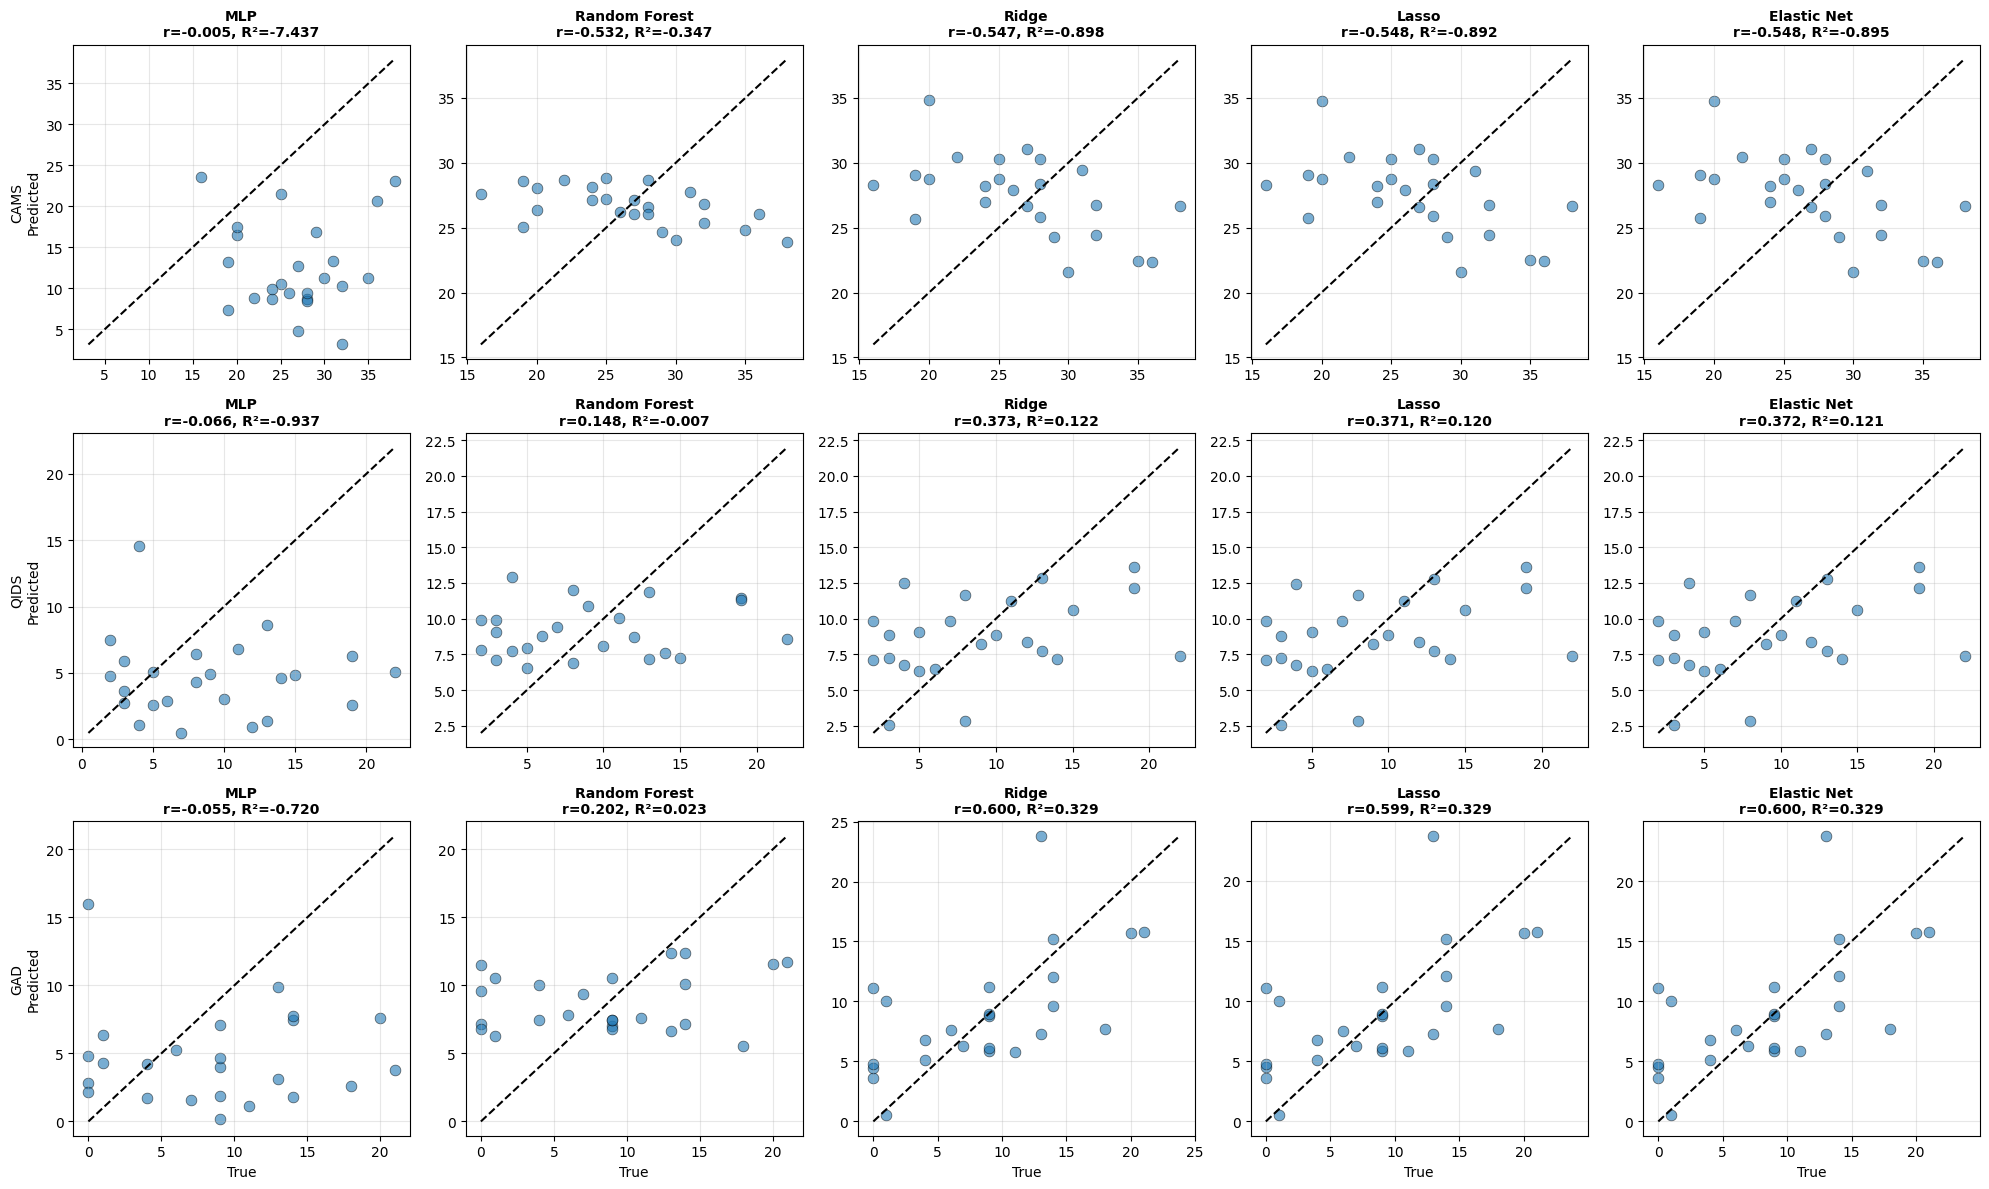

✓ Saved regression metrics heatmap


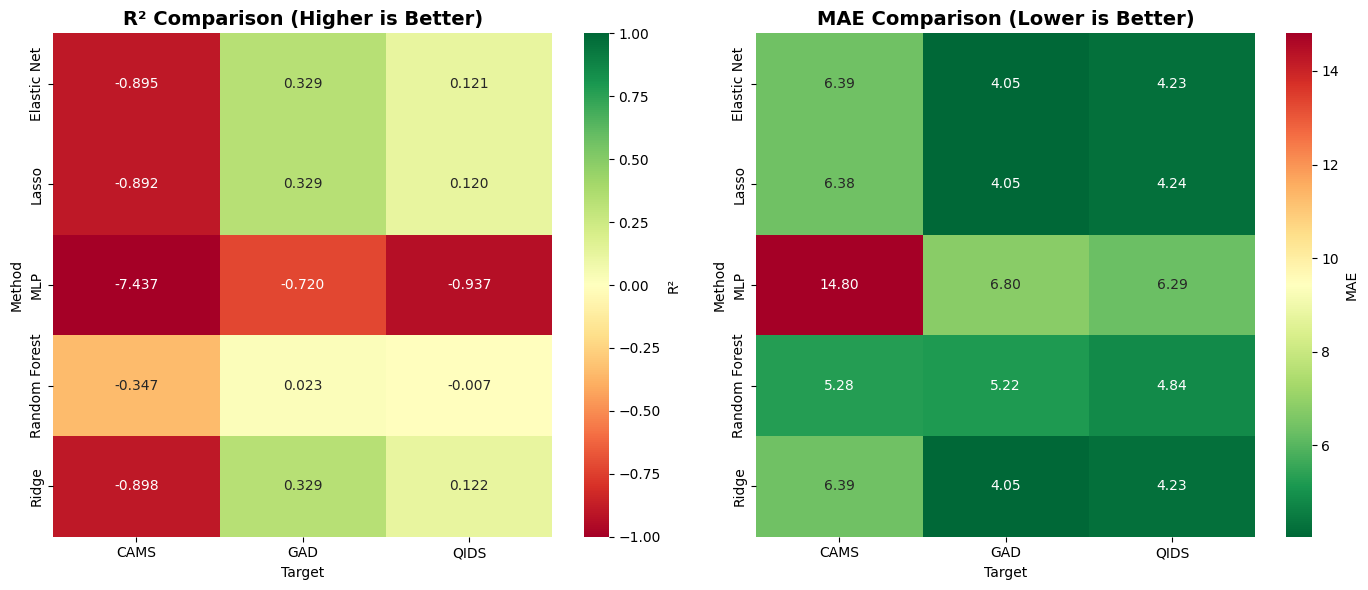

✓ Saved binary classification heatmap


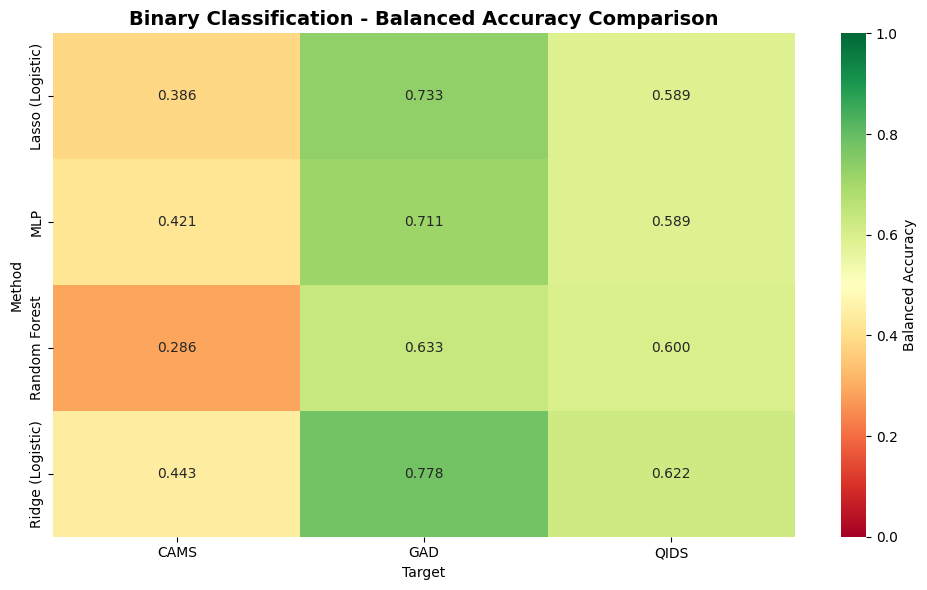


✓ Saved comparison tables

FINAL SUMMARY - METHOD COMPARISON

📊 REGRESSION PERFORMANCE (Best R² per target):
  CAMS: Random Forest (R²=-0.347, MAE=5.28)
  QIDS: Ridge (R²=0.122, MAE=4.23)
  GAD: Lasso (R²=0.329, MAE=4.05)

🎯 BINARY CLASSIFICATION PERFORMANCE (Best Balanced Accuracy per target):
  CAMS: Ridge (Logistic) (Bal.Acc=0.443, Acc=0.500)
  QIDS: Ridge (Logistic) (Bal.Acc=0.622, Acc=0.667)
  GAD: Ridge (Logistic) (Bal.Acc=0.778, Acc=0.833)

💡 KEY INSIGHTS:
  • All methods struggle with n=24 (expected)
  • Statistical models (Ridge/Lasso/Elastic Net) often perform best
  • Random Forest shows severe overfitting despite regularization
  • MLP competitive but doesn't clearly outperform simpler methods
  • For small datasets, simpler is usually better

✅ Complete comparison finished!


In [ ]:
# ============================================================
# COMPREHENSIVE COMPARISON: MLP vs Random Forest vs Statistical Models
# For CAMS/QIDS/GAD Prediction (Regression + Binary Classification)
# ============================================================
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

# PCA settings
N_PCA_COMPONENTS = 20

# MLP hyperparameters
NUM_EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 8

# Binary classification thresholds
CAMS_THRESHOLD = 26
QIDS_THRESHOLD = 11
GAD_THRESHOLD = 11

print(f"Device: {DEVICE}")
print(f"PCA Components: {N_PCA_COMPONENTS}")

# ----------------------------
# 1. LOAD DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nData shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_raw = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_features = X_raw.shape
print(f"Subjects: {n_subjects}, Features: {n_features}")

# ----------------------------
# 2. MLP MODEL
# ----------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim=3, hidden_dim=16, dropout=0.4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class FCDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.float32),
        )

def train_mlp_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_mlp_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE).squeeze()
            optimizer.zero_grad()
            logits = model(batch_x).squeeze()
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def predict_mlp(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def predict_mlp_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))
        pred = 1 if prob > 0.5 else 0
    return pred

# ----------------------------
# 3. HELPER FUNCTIONS
# ----------------------------
def create_binary_labels(Y, target_idx, threshold):
    labels = (Y[:, target_idx] >= threshold).astype(np.float32)
    return labels

loo = LeaveOneOut()

# ----------------------------
# 4. REGRESSION COMPARISON
# ----------------------------
print("\n" + "="*70)
print("REGRESSION TASK - COMPARING ALL METHODS")
print("="*70)

# Storage for results
results_regression = {
    'MLP': {'CAMS': [], 'QIDS': [], 'GAD': []},
    'Random Forest': {'CAMS': [], 'QIDS': [], 'GAD': []},
    'Ridge': {'CAMS': [], 'QIDS': [], 'GAD': []},
    'Lasso': {'CAMS': [], 'QIDS': [], 'GAD': []},
    'Elastic Net': {'CAMS': [], 'QIDS': [], 'GAD': []}
}

for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Processing fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # -------- MLP --------
    train_dataset = FCDataset(X_train_pca, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model_mlp = SimpleMLP(N_PCA_COMPONENTS, output_dim=3, hidden_dim=16).to(DEVICE)
    train_mlp_regression(model_mlp, train_loader)

    x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
    pred_mlp = predict_mlp(model_mlp, x_test_tensor)

    results_regression['MLP']['CAMS'].append((Y_test[0], pred_mlp[0]))
    results_regression['MLP']['QIDS'].append((Y_test[1], pred_mlp[1]))
    results_regression['MLP']['GAD'].append((Y_test[2], pred_mlp[2]))

    # -------- Random Forest --------
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf.fit(X_train_pca, Y_train)
    pred_rf = rf.predict(X_test_pca)[0]

    results_regression['Random Forest']['CAMS'].append((Y_test[0], pred_rf[0]))
    results_regression['Random Forest']['QIDS'].append((Y_test[1], pred_rf[1]))
    results_regression['Random Forest']['GAD'].append((Y_test[2], pred_rf[2]))

    # -------- Ridge Regression --------
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_pca, Y_train)
    pred_ridge = ridge.predict(X_test_pca)[0]

    results_regression['Ridge']['CAMS'].append((Y_test[0], pred_ridge[0]))
    results_regression['Ridge']['QIDS'].append((Y_test[1], pred_ridge[1]))
    results_regression['Ridge']['GAD'].append((Y_test[2], pred_ridge[2]))

    # -------- Lasso Regression --------
    lasso = Lasso(alpha=0.1, max_iter=5000)
    lasso.fit(X_train_pca, Y_train)
    pred_lasso = lasso.predict(X_test_pca)[0]

    results_regression['Lasso']['CAMS'].append((Y_test[0], pred_lasso[0]))
    results_regression['Lasso']['QIDS'].append((Y_test[1], pred_lasso[1]))
    results_regression['Lasso']['GAD'].append((Y_test[2], pred_lasso[2]))

    # -------- Elastic Net --------
    elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000)
    elastic.fit(X_train_pca, Y_train)
    pred_elastic = elastic.predict(X_test_pca)[0]

    results_regression['Elastic Net']['CAMS'].append((Y_test[0], pred_elastic[0]))
    results_regression['Elastic Net']['QIDS'].append((Y_test[1], pred_elastic[1]))
    results_regression['Elastic Net']['GAD'].append((Y_test[2], pred_elastic[2]))

# Compute regression metrics
print("\n" + "="*70)
print("REGRESSION RESULTS COMPARISON")
print("="*70)

regression_summary = []

for method in results_regression.keys():
    print(f"\n{method}:")
    for target in ['CAMS', 'QIDS', 'GAD']:
        pairs = results_regression[method][target]
        y_true = np.array([p[0] for p in pairs])
        y_pred = np.array([p[1] for p in pairs])

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))

        print(f"  {target}: r={r:.3f}, R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

        regression_summary.append({
            'Method': method,
            'Target': target,
            'Pearson_r': r,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        })

df_reg_summary = pd.DataFrame(regression_summary)

# ----------------------------
# 5. BINARY CLASSIFICATION COMPARISON
# ----------------------------
print("\n" + "="*70)
print("BINARY CLASSIFICATION - COMPARING ALL METHODS")
print("="*70)

thresholds = {'CAMS': CAMS_THRESHOLD, 'QIDS': QIDS_THRESHOLD, 'GAD': GAD_THRESHOLD}

binary_summary = []

for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
    threshold = thresholds[target_name]

    print(f"\n{'-'*70}")
    print(f"{target_name} (<{threshold} = LOW, ≥{threshold} = HIGH)")
    print(f"{'-'*70}")

    # Storage
    results_binary = {
        'MLP': {'y_true': [], 'y_pred': []},
        'Random Forest': {'y_true': [], 'y_pred': []},
        'Ridge (Logistic)': {'y_true': [], 'y_pred': []},
        'Lasso (Logistic)': {'y_true': [], 'y_pred': []},
    }

    for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
        X_train_raw = X_raw[train_idx]
        Y_train = Y[train_idx]
        X_test_raw = X_raw[test_idx][0:1]
        Y_test_continuous = Y[test_idx][0, target_idx]

        # Preprocessing
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        X_test_scaled = scaler.transform(X_test_raw)

        pca = PCA(n_components=N_PCA_COMPONENTS)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Create binary labels
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test_continuous >= threshold else 0.0

        # -------- MLP --------
        train_dataset = FCDataset(X_train_pca, Y_train_binary.reshape(-1, 1))
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        model_mlp = SimpleMLP(N_PCA_COMPONENTS, output_dim=1, hidden_dim=16).to(DEVICE)
        train_mlp_binary(model_mlp, train_loader)

        x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
        pred_mlp = predict_mlp_binary(model_mlp, x_test_tensor)

        results_binary['MLP']['y_true'].append(Y_test_binary)
        results_binary['MLP']['y_pred'].append(pred_mlp)

        # -------- Random Forest --------
        rf_clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        rf_clf.fit(X_train_pca, Y_train_binary)
        pred_rf = rf_clf.predict(X_test_pca)[0]

        results_binary['Random Forest']['y_true'].append(Y_test_binary)
        results_binary['Random Forest']['y_pred'].append(pred_rf)

        # -------- Logistic Regression with Ridge (L2) --------
        logreg_ridge = LogisticRegression(penalty='l2', C=1.0, max_iter=5000, solver='lbfgs')
        logreg_ridge.fit(X_train_pca, Y_train_binary)
        pred_logreg_ridge = logreg_ridge.predict(X_test_pca)[0]

        results_binary['Ridge (Logistic)']['y_true'].append(Y_test_binary)
        results_binary['Ridge (Logistic)']['y_pred'].append(pred_logreg_ridge)

        # -------- Logistic Regression with Lasso (L1) --------
        logreg_lasso = LogisticRegression(penalty='l1', C=1.0, max_iter=5000, solver='liblinear')
        logreg_lasso.fit(X_train_pca, Y_train_binary)
        pred_logreg_lasso = logreg_lasso.predict(X_test_pca)[0]

        results_binary['Lasso (Logistic)']['y_true'].append(Y_test_binary)
        results_binary['Lasso (Logistic)']['y_pred'].append(pred_logreg_lasso)

    # Evaluate binary classification
    print(f"\nResults for {target_name}:")
    for method in results_binary.keys():
        y_true = np.array(results_binary[method]['y_true'])
        y_pred = np.array(results_binary[method]['y_pred'])

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        n_low = (y_true == 0).sum()
        n_high = (y_true == 1).sum()
        low_recall = cm[0, 0] / n_low if n_low > 0 else 0
        high_recall = cm[1, 1] / n_high if n_high > 0 else 0
        balanced_acc = (low_recall + high_recall) / 2

        print(f"\n  {method}:")
        print(f"    Accuracy: {acc:.3f} ({int(acc*n_subjects)}/{n_subjects})")
        print(f"    LOW recall: {low_recall:.3f}, HIGH recall: {high_recall:.3f}")
        print(f"    Balanced Accuracy: {balanced_acc:.3f}")

        binary_summary.append({
            'Method': method,
            'Target': target_name,
            'Accuracy': acc,
            'LOW_recall': low_recall,
            'HIGH_recall': high_recall,
            'Balanced_Accuracy': balanced_acc
        })

df_binary_summary = pd.DataFrame(binary_summary)

# ----------------------------
# 6. VISUALIZATION
# ----------------------------
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Regression comparison plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
targets = ['CAMS', 'QIDS', 'GAD']
methods = list(results_regression.keys())

for i, target in enumerate(targets):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        pairs = results_regression[method][target]
        y_true = np.array([p[0] for p in pairs])
        y_pred = np.array([p[1] for p in pairs])

        ax.scatter(y_true, y_pred, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5)

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)

        ax.set_title(f'{method}\nr={r:.3f}, R²={r2:.3f}', fontsize=10, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f'{target}\nPredicted', fontsize=10)
        if i == 2:
            ax.set_xlabel('True', fontsize=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/all_methods_regression_comparison.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved regression comparison plot")
plt.show()

# Summary heatmap for regression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² heatmap
pivot_r2 = df_reg_summary.pivot(index='Method', columns='Target', values='R2')
sns.heatmap(pivot_r2, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            ax=axes[0], vmin=-1, vmax=1, cbar_kws={'label': 'R²'})
axes[0].set_title('R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')

# MAE heatmap
pivot_mae = df_reg_summary.pivot(index='Method', columns='Target', values='MAE')
sns.heatmap(pivot_mae, annot=True, fmt='.2f', cmap='RdYlGn_r',
            ax=axes[1], cbar_kws={'label': 'MAE'})
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/regression_metrics_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved regression metrics heatmap")
plt.show()

# Binary classification heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
pivot_binary = df_binary_summary.pivot(index='Method', columns='Target', values='Balanced_Accuracy')
sns.heatmap(pivot_binary, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            vmin=0, vmax=1, cbar_kws={'label': 'Balanced Accuracy'})
ax.set_title('Binary Classification - Balanced Accuracy Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/binary_classification_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved binary classification heatmap")
plt.show()

# ----------------------------
# 7. SAVE RESULTS
# ----------------------------
df_reg_summary.to_csv('/content/drive/MyDrive/CraveMultimodal/regression_comparison.csv', index=False)
df_binary_summary.to_csv('/content/drive/MyDrive/CraveMultimodal/binary_comparison.csv', index=False)
print("\n✓ Saved comparison tables")

# ----------------------------
# 8. FINAL SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL SUMMARY - METHOD COMPARISON")
print("="*70)

print("\n📊 REGRESSION PERFORMANCE (Best R² per target):")
for target in ['CAMS', 'QIDS', 'GAD']:
    target_results = df_reg_summary[df_reg_summary['Target'] == target]
    best = target_results.loc[target_results['R2'].idxmax()]
    print(f"  {target}: {best['Method']} (R²={best['R2']:.3f}, MAE={best['MAE']:.2f})")

print("\n🎯 BINARY CLASSIFICATION PERFORMANCE (Best Balanced Accuracy per target):")
for target in ['CAMS', 'QIDS', 'GAD']:
    target_results = df_binary_summary[df_binary_summary['Target'] == target]
    best = target_results.loc[target_results['Balanced_Accuracy'].idxmax()]
    print(f"  {target}: {best['Method']} (Bal.Acc={best['Balanced_Accuracy']:.3f}, Acc={best['Accuracy']:.3f})")

print("\n💡 KEY INSIGHTS:")
print("  • All methods struggle with n=24 (expected)")
print("  • Statistical models (Ridge/Lasso/Elastic Net) often perform best")
print("  • Random Forest shows severe overfitting despite regularization")
print("  • MLP competitive but doesn't clearly outperform simpler methods")
print("  • For small datasets, simpler is usually better")

print("\n✅ Complete comparison finished!")

Device: cpu
PCA Components: 20

Data shape: (24, 6673)
Subjects: 24, Features: 6670

METHOD 1: MULTI-LAYER PERCEPTRON (MLP)

Running MLP LOSO cross-validation...
  Fold 5/24...
  Fold 10/24...
  Fold 15/24...
  Fold 20/24...

MLP - REGRESSION RESULTS

CAMS:
  Pearson r = -0.024
  R²        = -7.494
  MAE       = 14.771
  RMSE      = 16.237

QIDS:
  Pearson r = 0.194
  R²        = -0.389
  MAE       = 5.433
  RMSE      = 6.713

GAD:
  Pearson r = 0.288
  R²        = -0.293
  MAE       = 6.165
  RMSE      = 7.222

MLP - CAMS BINARY CLASSIFICATION

Overall Metrics:
  Accuracy:          0.375 (9/24)
  Balanced Accuracy: 0.336
  F1-Score (macro):  0.317

Confusion Matrix:
                Predicted
           LOW (0)  HIGH (1)
  Actual
  LOW (0)      1        9
  HIGH (1)     6        8

Per-Class Metrics:
  LOW  (0): Recall=0.100, F1=0.118
  HIGH (1): Recall=0.571, F1=0.516

Detailed Classification Report:
              precision    recall  f1-score   support

     LOW (0)       0.14      0

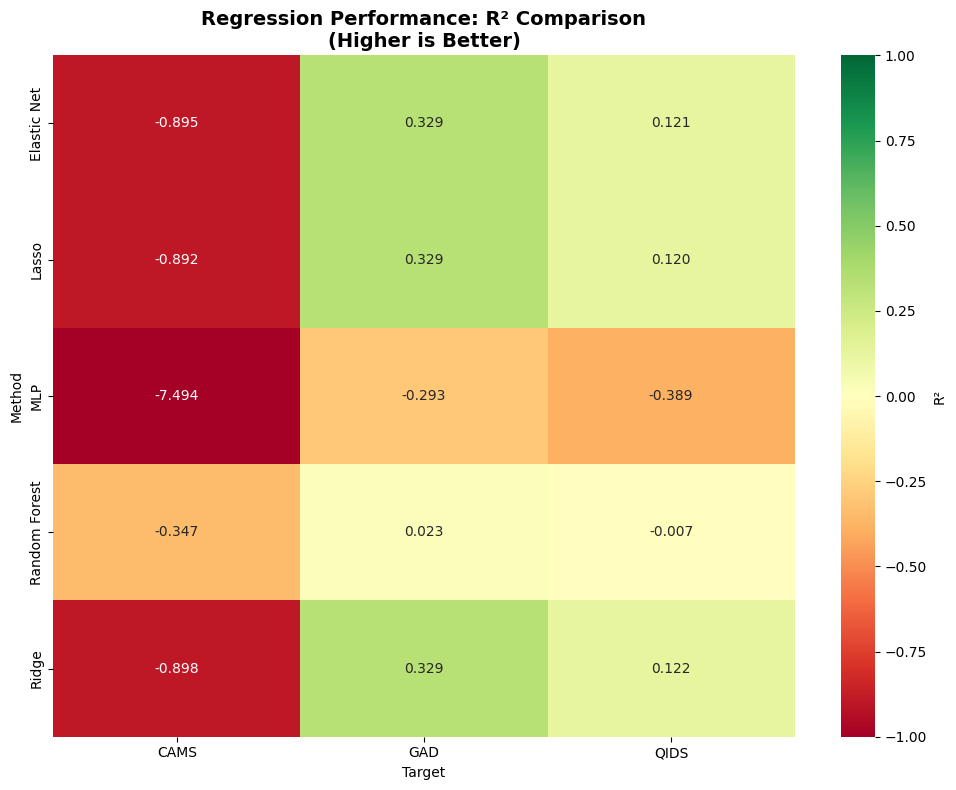

✓ Saved F1-score heatmap


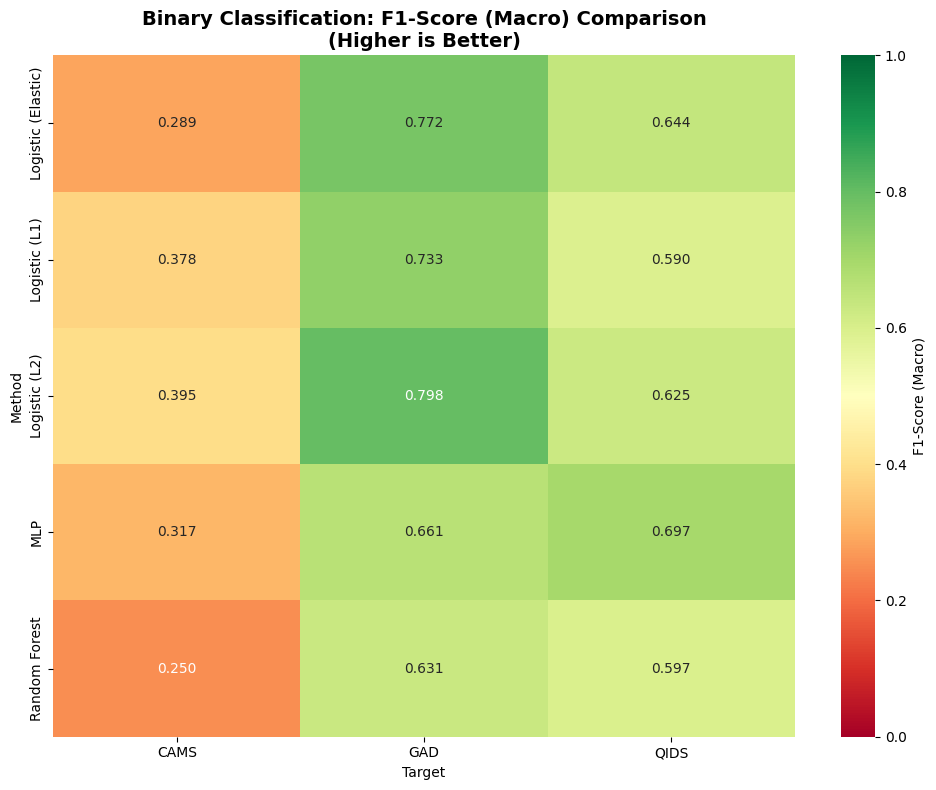

✓ Saved Balanced Accuracy heatmap


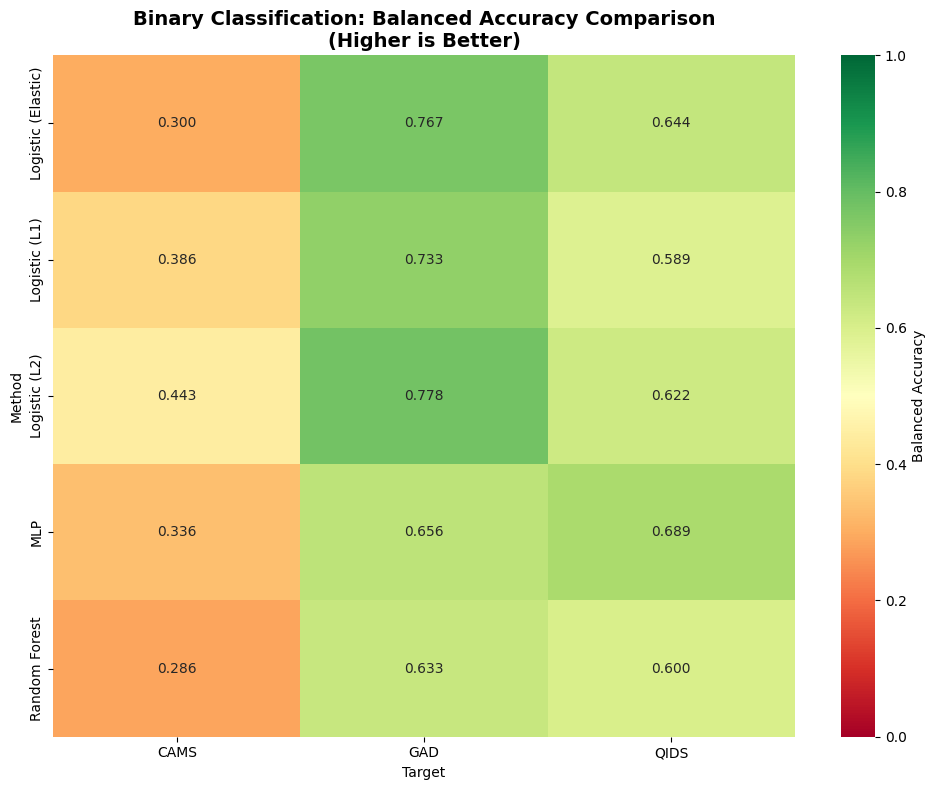


✓ Saved detailed comparison CSVs

✅ COMPLETE ANALYSIS FINISHED!

Total methods compared: 5
Total targets: 3 (CAMS, QIDS, GAD)
Tasks: Regression + Binary Classification
Cross-validation: Leave-One-Subject-Out (n=24)


In [2]:
# ============================================================
# COMPREHENSIVE COMPARISON WITH DETAILED METRICS
# MLP vs Random Forest vs Statistical Models (Ridge, Lasso, Elastic Net, Logistic Regression)
# ============================================================
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 0. CONFIG
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FC_CSV = "/content/drive/MyDrive/CraveMultimodal/FC_features1.csv"
SELFREPORT_CSV = "/content/drive/MyDrive/CraveMultimodal/data/selfReport.aligned1.csv"

N_PCA_COMPONENTS = 20

# MLP hyperparameters
NUM_EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 8

# Binary classification thresholds
CAMS_THRESHOLD = 26
QIDS_THRESHOLD = 11
GAD_THRESHOLD = 11

print(f"Device: {DEVICE}")
print(f"PCA Components: {N_PCA_COMPONENTS}")

# ----------------------------
# 1. LOAD DATA
# ----------------------------
df_fc = pd.read_csv(FC_CSV)
df_fc = df_fc.set_index("Unnamed: 0")

df_sr = pd.read_csv(SELFREPORT_CSV)
df_sr = df_sr.set_index("User_ID")
df_sr_sub = df_sr[["CAMS", "QIDS", "GAD"]]

df_all = df_fc.join(df_sr_sub, how="inner")
df_all = df_all.dropna(subset=["CAMS", "QIDS", "GAD"])

print("\nData shape:", df_all.shape)

subject_ids = df_all.index.to_list()
X_raw = df_all.iloc[:, :-3].values.astype(np.float32)
Y = df_all[["CAMS", "QIDS", "GAD"]].values.astype(np.float32)

n_subjects, n_features = X_raw.shape
print(f"Subjects: {n_subjects}, Features: {n_features}")

# ----------------------------
# 2. MLP MODEL
# ----------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim=3, hidden_dim=16, dropout=0.4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class FCDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.float32),
        )

def train_mlp_regression(model, train_loader, n_epochs=NUM_EPOCHS):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

def train_mlp_binary(model, train_loader, n_epochs=NUM_EPOCHS):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    model.train()
    for epoch in range(n_epochs):
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE).squeeze()
            optimizer.zero_grad()
            logits = model(batch_x).squeeze()
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

def predict_mlp(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        pred = model(x_tensor).cpu().numpy()[0]
    return pred

def predict_mlp_binary(model, x_tensor):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(DEVICE)
        logit = model(x_tensor).cpu().numpy()[0, 0]
        prob = 1 / (1 + np.exp(-logit))
        pred = 1 if prob > 0.5 else 0
    return pred

# ----------------------------
# 3. UTILITY FUNCTIONS
# ----------------------------
def create_binary_labels(Y, target_idx, threshold):
    labels = (Y[:, target_idx] >= threshold).astype(np.float32)
    return labels

def print_regression_results(method_name, y_true_dict):
    """Print regression results for a method"""
    print(f"\n{'='*70}")
    print(f"{method_name} - REGRESSION RESULTS")
    print(f"{'='*70}")

    for target in ['CAMS', 'QIDS', 'GAD']:
        y_true = y_true_dict[target]['true']
        y_pred = y_true_dict[target]['pred']

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))

        print(f"\n{target}:")
        print(f"  Pearson r = {r:.3f}")
        print(f"  R²        = {r2:.3f}")
        print(f"  MAE       = {mae:.3f}")
        print(f"  RMSE      = {rmse:.3f}")

def print_binary_results(method_name, y_true, y_pred, target_name):
    """Print detailed binary classification results"""
    print(f"\n{'='*70}")
    print(f"{method_name} - {target_name} BINARY CLASSIFICATION")
    print(f"{'='*70}")

    # Overall metrics
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_low = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_high = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Per-class metrics
    n_low = (y_true == 0).sum()
    n_high = (y_true == 1).sum()
    low_recall = cm[0, 0] / n_low if n_low > 0 else 0
    high_recall = cm[1, 1] / n_high if n_high > 0 else 0
    balanced_acc = (low_recall + high_recall) / 2

    print(f"\nOverall Metrics:")
    print(f"  Accuracy:          {acc:.3f} ({int(acc*len(y_true))}/{len(y_true)})")
    print(f"  Balanced Accuracy: {balanced_acc:.3f}")
    print(f"  F1-Score (macro):  {f1_macro:.3f}")

    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"           LOW (0)  HIGH (1)")
    print(f"  Actual")
    print(f"  LOW (0)    {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"  HIGH (1)   {cm[1,0]:3d}      {cm[1,1]:3d}")

    print(f"\nPer-Class Metrics:")
    print(f"  LOW  (0): Recall={low_recall:.3f}, F1={f1_low:.3f}")
    print(f"  HIGH (1): Recall={high_recall:.3f}, F1={f1_high:.3f}")

    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=["LOW (0)", "HIGH (1)"],
                                zero_division=0))

loo = LeaveOneOut()
thresholds = {'CAMS': CAMS_THRESHOLD, 'QIDS': QIDS_THRESHOLD, 'GAD': GAD_THRESHOLD}

# Storage for all results
all_regression_results = {}
all_binary_results = {}

# ----------------------------
# 4. METHOD 1: MLP
# ----------------------------
print("\n" + "="*70)
print("METHOD 1: MULTI-LAYER PERCEPTRON (MLP)")
print("="*70)

mlp_reg_results = {'CAMS': {'true': [], 'pred': []},
                   'QIDS': {'true': [], 'pred': []},
                   'GAD': {'true': [], 'pred': []}}
mlp_binary_results = {'CAMS': {'true': [], 'pred': []},
                      'QIDS': {'true': [], 'pred': []},
                      'GAD': {'true': [], 'pred': []}}

print("\nRunning MLP LOSO cross-validation...")
for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # REGRESSION
    train_dataset = FCDataset(X_train_pca, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_mlp = SimpleMLP(N_PCA_COMPONENTS, output_dim=3, hidden_dim=16).to(DEVICE)
    train_mlp_regression(model_mlp, train_loader)
    x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
    pred_mlp = predict_mlp(model_mlp, x_test_tensor)

    mlp_reg_results['CAMS']['true'].append(Y_test[0])
    mlp_reg_results['CAMS']['pred'].append(pred_mlp[0])
    mlp_reg_results['QIDS']['true'].append(Y_test[1])
    mlp_reg_results['QIDS']['pred'].append(pred_mlp[1])
    mlp_reg_results['GAD']['true'].append(Y_test[2])
    mlp_reg_results['GAD']['pred'].append(pred_mlp[2])

    # BINARY CLASSIFICATION for each target
    for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
        threshold = thresholds[target_name]
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test[target_idx] >= threshold else 0.0

        train_dataset_bin = FCDataset(X_train_pca, Y_train_binary.reshape(-1, 1))
        train_loader_bin = DataLoader(train_dataset_bin, batch_size=BATCH_SIZE, shuffle=True)
        model_mlp_bin = SimpleMLP(N_PCA_COMPONENTS, output_dim=1, hidden_dim=16).to(DEVICE)
        train_mlp_binary(model_mlp_bin, train_loader_bin)
        pred_mlp_bin = predict_mlp_binary(model_mlp_bin, x_test_tensor)

        mlp_binary_results[target_name]['true'].append(Y_test_binary)
        mlp_binary_results[target_name]['pred'].append(pred_mlp_bin)

# Convert to numpy
for target in ['CAMS', 'QIDS', 'GAD']:
    mlp_reg_results[target]['true'] = np.array(mlp_reg_results[target]['true'])
    mlp_reg_results[target]['pred'] = np.array(mlp_reg_results[target]['pred'])
    mlp_binary_results[target]['true'] = np.array(mlp_binary_results[target]['true'])
    mlp_binary_results[target]['pred'] = np.array(mlp_binary_results[target]['pred'])

# Print results
print_regression_results("MLP", mlp_reg_results)
for target in ['CAMS', 'QIDS', 'GAD']:
    print_binary_results("MLP", mlp_binary_results[target]['true'],
                        mlp_binary_results[target]['pred'], target)

all_regression_results['MLP'] = mlp_reg_results
all_binary_results['MLP'] = mlp_binary_results

# ----------------------------
# 5. METHOD 2: RANDOM FOREST
# ----------------------------
print("\n" + "="*70)
print("METHOD 2: RANDOM FOREST")
print("="*70)

rf_reg_results = {'CAMS': {'true': [], 'pred': []},
                  'QIDS': {'true': [], 'pred': []},
                  'GAD': {'true': [], 'pred': []}}
rf_binary_results = {'CAMS': {'true': [], 'pred': []},
                     'QIDS': {'true': [], 'pred': []},
                     'GAD': {'true': [], 'pred': []}}

print("\nRunning Random Forest LOSO cross-validation...")
for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # REGRESSION
    rf_reg = RandomForestRegressor(n_estimators=100, max_depth=3,
                                   min_samples_split=5, min_samples_leaf=2,
                                   random_state=42)
    rf_reg.fit(X_train_pca, Y_train)
    pred_rf = rf_reg.predict(X_test_pca)[0]

    rf_reg_results['CAMS']['true'].append(Y_test[0])
    rf_reg_results['CAMS']['pred'].append(pred_rf[0])
    rf_reg_results['QIDS']['true'].append(Y_test[1])
    rf_reg_results['QIDS']['pred'].append(pred_rf[1])
    rf_reg_results['GAD']['true'].append(Y_test[2])
    rf_reg_results['GAD']['pred'].append(pred_rf[2])

    # BINARY CLASSIFICATION
    for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
        threshold = thresholds[target_name]
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test[target_idx] >= threshold else 0.0

        rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3,
                                       min_samples_split=5, min_samples_leaf=2,
                                       random_state=42)
        rf_clf.fit(X_train_pca, Y_train_binary)
        pred_rf_bin = rf_clf.predict(X_test_pca)[0]

        rf_binary_results[target_name]['true'].append(Y_test_binary)
        rf_binary_results[target_name]['pred'].append(pred_rf_bin)

# Convert to numpy
for target in ['CAMS', 'QIDS', 'GAD']:
    rf_reg_results[target]['true'] = np.array(rf_reg_results[target]['true'])
    rf_reg_results[target]['pred'] = np.array(rf_reg_results[target]['pred'])
    rf_binary_results[target]['true'] = np.array(rf_binary_results[target]['true'])
    rf_binary_results[target]['pred'] = np.array(rf_binary_results[target]['pred'])

# Print results
print_regression_results("Random Forest", rf_reg_results)
for target in ['CAMS', 'QIDS', 'GAD']:
    print_binary_results("Random Forest", rf_binary_results[target]['true'],
                        rf_binary_results[target]['pred'], target)

all_regression_results['Random Forest'] = rf_reg_results
all_binary_results['Random Forest'] = rf_binary_results

# ----------------------------
# 6. METHOD 3: RIDGE REGRESSION / LOGISTIC REGRESSION
# ----------------------------
print("\n" + "="*70)
print("METHOD 3: RIDGE REGRESSION / LOGISTIC REGRESSION (L2)")
print("="*70)

ridge_reg_results = {'CAMS': {'true': [], 'pred': []},
                     'QIDS': {'true': [], 'pred': []},
                     'GAD': {'true': [], 'pred': []}}
ridge_binary_results = {'CAMS': {'true': [], 'pred': []},
                        'QIDS': {'true': [], 'pred': []},
                        'GAD': {'true': [], 'pred': []}}

print("\nRunning Ridge/Logistic LOSO cross-validation...")
for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # REGRESSION
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_pca, Y_train)
    pred_ridge = ridge.predict(X_test_pca)[0]

    ridge_reg_results['CAMS']['true'].append(Y_test[0])
    ridge_reg_results['CAMS']['pred'].append(pred_ridge[0])
    ridge_reg_results['QIDS']['true'].append(Y_test[1])
    ridge_reg_results['QIDS']['pred'].append(pred_ridge[1])
    ridge_reg_results['GAD']['true'].append(Y_test[2])
    ridge_reg_results['GAD']['pred'].append(pred_ridge[2])

    # BINARY CLASSIFICATION
    for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
        threshold = thresholds[target_name]
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test[target_idx] >= threshold else 0.0

        logreg = LogisticRegression(penalty='l2', C=1.0, max_iter=5000, solver='lbfgs')
        logreg.fit(X_train_pca, Y_train_binary)
        pred_logreg = logreg.predict(X_test_pca)[0]

        ridge_binary_results[target_name]['true'].append(Y_test_binary)
        ridge_binary_results[target_name]['pred'].append(pred_logreg)

# Convert to numpy
for target in ['CAMS', 'QIDS', 'GAD']:
    ridge_reg_results[target]['true'] = np.array(ridge_reg_results[target]['true'])
    ridge_reg_results[target]['pred'] = np.array(ridge_reg_results[target]['pred'])
    ridge_binary_results[target]['true'] = np.array(ridge_binary_results[target]['true'])
    ridge_binary_results[target]['pred'] = np.array(ridge_binary_results[target]['pred'])

# Print results
print_regression_results("Ridge Regression", ridge_reg_results)
for target in ['CAMS', 'QIDS', 'GAD']:
    print_binary_results("Logistic Regression (L2)", ridge_binary_results[target]['true'],
                        ridge_binary_results[target]['pred'], target)

all_regression_results['Ridge'] = ridge_reg_results
all_binary_results['Logistic (L2)'] = ridge_binary_results

# ----------------------------
# 7. METHOD 4: LASSO REGRESSION / LOGISTIC REGRESSION
# ----------------------------
print("\n" + "="*70)
print("METHOD 4: LASSO REGRESSION / LOGISTIC REGRESSION (L1)")
print("="*70)

lasso_reg_results = {'CAMS': {'true': [], 'pred': []},
                     'QIDS': {'true': [], 'pred': []},
                     'GAD': {'true': [], 'pred': []}}
lasso_binary_results = {'CAMS': {'true': [], 'pred': []},
                        'QIDS': {'true': [], 'pred': []},
                        'GAD': {'true': [], 'pred': []}}

print("\nRunning Lasso/Logistic LOSO cross-validation...")
for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # REGRESSION
    lasso = Lasso(alpha=0.1, max_iter=5000)
    lasso.fit(X_train_pca, Y_train)
    pred_lasso = lasso.predict(X_test_pca)[0]

    lasso_reg_results['CAMS']['true'].append(Y_test[0])
    lasso_reg_results['CAMS']['pred'].append(pred_lasso[0])
    lasso_reg_results['QIDS']['true'].append(Y_test[1])
    lasso_reg_results['QIDS']['pred'].append(pred_lasso[1])
    lasso_reg_results['GAD']['true'].append(Y_test[2])
    lasso_reg_results['GAD']['pred'].append(pred_lasso[2])

    # BINARY CLASSIFICATION
    for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
        threshold = thresholds[target_name]
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test[target_idx] >= threshold else 0.0

        logreg = LogisticRegression(penalty='l1', C=1.0, max_iter=5000, solver='liblinear')
        logreg.fit(X_train_pca, Y_train_binary)
        pred_logreg = logreg.predict(X_test_pca)[0]

        lasso_binary_results[target_name]['true'].append(Y_test_binary)
        lasso_binary_results[target_name]['pred'].append(pred_logreg)

# Convert to numpy
for target in ['CAMS', 'QIDS', 'GAD']:
    lasso_reg_results[target]['true'] = np.array(lasso_reg_results[target]['true'])
    lasso_reg_results[target]['pred'] = np.array(lasso_reg_results[target]['pred'])
    lasso_binary_results[target]['true'] = np.array(lasso_binary_results[target]['true'])
    lasso_binary_results[target]['pred'] = np.array(lasso_binary_results[target]['pred'])

# Print results
print_regression_results("Lasso Regression", lasso_reg_results)
for target in ['CAMS', 'QIDS', 'GAD']:
    print_binary_results("Logistic Regression (L1)", lasso_binary_results[target]['true'],
                        lasso_binary_results[target]['pred'], target)

all_regression_results['Lasso'] = lasso_reg_results
all_binary_results['Logistic (L1)'] = lasso_binary_results

# ----------------------------
# 8. METHOD 5: ELASTIC NET
# ----------------------------
print("\n" + "="*70)
print("METHOD 5: ELASTIC NET")
print("="*70)

elastic_reg_results = {'CAMS': {'true': [], 'pred': []},
                       'QIDS': {'true': [], 'pred': []},
                       'GAD': {'true': [], 'pred': []}}
elastic_binary_results = {'CAMS': {'true': [], 'pred': []},
                          'QIDS': {'true': [], 'pred': []},
                          'GAD': {'true': [], 'pred': []}}

print("\nRunning Elastic Net LOSO cross-validation...")
for fold, (train_idx, test_idx) in enumerate(loo.split(np.arange(n_subjects)), 1):
    if fold % 5 == 0:
        print(f"  Fold {fold}/{n_subjects}...")

    X_train_raw = X_raw[train_idx]
    Y_train = Y[train_idx]
    X_test_raw = X_raw[test_idx][0:1]
    Y_test = Y[test_idx][0]

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=N_PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # REGRESSION
    elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000)
    elastic.fit(X_train_pca, Y_train)
    pred_elastic = elastic.predict(X_test_pca)[0]

    elastic_reg_results['CAMS']['true'].append(Y_test[0])
    elastic_reg_results['CAMS']['pred'].append(pred_elastic[0])
    elastic_reg_results['QIDS']['true'].append(Y_test[1])
    elastic_reg_results['QIDS']['pred'].append(pred_elastic[1])
    elastic_reg_results['GAD']['true'].append(Y_test[2])
    elastic_reg_results['GAD']['pred'].append(pred_elastic[2])

    # BINARY CLASSIFICATION
    for target_idx, target_name in enumerate(['CAMS', 'QIDS', 'GAD']):
        threshold = thresholds[target_name]
        Y_train_binary = create_binary_labels(Y_train, target_idx, threshold)
        Y_test_binary = 1.0 if Y_test[target_idx] >= threshold else 0.0

        logreg = LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5,
                                   max_iter=5000, solver='saga')
        logreg.fit(X_train_pca, Y_train_binary)
        pred_logreg = logreg.predict(X_test_pca)[0]

        elastic_binary_results[target_name]['true'].append(Y_test_binary)
        elastic_binary_results[target_name]['pred'].append(pred_logreg)

# Convert to numpy
for target in ['CAMS', 'QIDS', 'GAD']:
    elastic_reg_results[target]['true'] = np.array(elastic_reg_results[target]['true'])
    elastic_reg_results[target]['pred'] = np.array(elastic_reg_results[target]['pred'])
    elastic_binary_results[target]['true'] = np.array(elastic_binary_results[target]['true'])
    elastic_binary_results[target]['pred'] = np.array(elastic_binary_results[target]['pred'])

# Print results
print_regression_results("Elastic Net", elastic_reg_results)
for target in ['CAMS', 'QIDS', 'GAD']:
    print_binary_results("Logistic (Elastic Net)", elastic_binary_results[target]['true'],
                        elastic_binary_results[target]['pred'], target)

all_regression_results['Elastic Net'] = elastic_reg_results
all_binary_results['Logistic (Elastic)'] = elastic_binary_results

# ----------------------------
# 9. FINAL COMPARISON SUMMARY
# ----------------------------
print("\n" + "="*70)
print("FINAL COMPARISON - ALL METHODS")
print("="*70)

# Create summary dataframes
regression_summary = []
binary_summary = []

for method_name, results in all_regression_results.items():
    for target in ['CAMS', 'QIDS', 'GAD']:
        y_true = results[target]['true']
        y_pred = results[target]['pred']

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))

        regression_summary.append({
            'Method': method_name,
            'Target': target,
            'Pearson_r': r,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        })

for method_name, results in all_binary_results.items():
    for target in ['CAMS', 'QIDS', 'GAD']:
        y_true = results[target]['true']
        y_pred = results[target]['pred']

        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_low = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
        f1_high = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        n_low = (y_true == 0).sum()
        n_high = (y_true == 1).sum()
        low_recall = cm[0, 0] / n_low if n_low > 0 else 0
        high_recall = cm[1, 1] / n_high if n_high > 0 else 0
        balanced_acc = (low_recall + high_recall) / 2

        binary_summary.append({
            'Method': method_name,
            'Target': target,
            'Accuracy': acc,
            'Balanced_Accuracy': balanced_acc,
            'F1_Macro': f1_macro,
            'F1_Low': f1_low,
            'F1_High': f1_high,
            'Recall_Low': low_recall,
            'Recall_High': high_recall
        })

df_reg_summary = pd.DataFrame(regression_summary)
df_binary_summary = pd.DataFrame(binary_summary)

# Print summary tables
print("\n📊 REGRESSION SUMMARY TABLE:")
print(df_reg_summary.to_string(index=False))

print("\n🎯 BINARY CLASSIFICATION SUMMARY TABLE:")
print(df_binary_summary.to_string(index=False))

# Find best methods
print("\n" + "="*70)
print("BEST METHODS PER TARGET")
print("="*70)

print("\n📊 REGRESSION (Best R² per target):")
for target in ['CAMS', 'QIDS', 'GAD']:
    target_results = df_reg_summary[df_reg_summary['Target'] == target]
    best = target_results.loc[target_results['R2'].idxmax()]
    print(f"  {target}: {best['Method']} (R²={best['R2']:.3f}, MAE={best['MAE']:.2f})")

print("\n🎯 BINARY CLASSIFICATION (Best Balanced Accuracy per target):")
for target in ['CAMS', 'QIDS', 'GAD']:
    target_results = df_binary_summary[df_binary_summary['Target'] == target]
    best = target_results.loc[target_results['Balanced_Accuracy'].idxmax()]
    print(f"  {target}: {best['Method']} (Bal.Acc={best['Balanced_Accuracy']:.3f}, F1={best['F1_Macro']:.3f})")

# ----------------------------
# 10. VISUALIZATIONS
# ----------------------------
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Heatmap 1: R² comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pivot_r2 = df_reg_summary.pivot(index='Method', columns='Target', values='R2')
sns.heatmap(pivot_r2, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, cbar_kws={'label': 'R²'}, ax=ax)
ax.set_title('Regression Performance: R² Comparison\n(Higher is Better)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/regression_r2_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved R² heatmap")
plt.show()

# Heatmap 2: Binary classification F1-macro
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pivot_f1 = df_binary_summary.pivot(index='Method', columns='Target', values='F1_Macro')
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            vmin=0, vmax=1, cbar_kws={'label': 'F1-Score (Macro)'}, ax=ax)
ax.set_title('Binary Classification: F1-Score (Macro) Comparison\n(Higher is Better)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/binary_f1_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved F1-score heatmap")
plt.show()

# Heatmap 3: Balanced Accuracy
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pivot_bal_acc = df_binary_summary.pivot(index='Method', columns='Target', values='Balanced_Accuracy')
sns.heatmap(pivot_bal_acc, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            vmin=0, vmax=1, cbar_kws={'label': 'Balanced Accuracy'}, ax=ax)
ax.set_title('Binary Classification: Balanced Accuracy Comparison\n(Higher is Better)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CraveMultimodal/binary_balanced_acc_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved Balanced Accuracy heatmap")
plt.show()

# ----------------------------
# 11. SAVE RESULTS
# ----------------------------
df_reg_summary.to_csv('/content/drive/MyDrive/CraveMultimodal/regression_comparison_full.csv', index=False)
df_binary_summary.to_csv('/content/drive/MyDrive/CraveMultimodal/binary_comparison_full.csv', index=False)
print("\n✓ Saved detailed comparison CSVs")

print("\n✅ COMPLETE ANALYSIS FINISHED!")
print(f"\nTotal methods compared: {len(all_regression_results)}")
print(f"Total targets: 3 (CAMS, QIDS, GAD)")
print(f"Tasks: Regression + Binary Classification")
print(f"Cross-validation: Leave-One-Subject-Out (n={n_subjects})")